# Media Effect Estimation with PyMC: Adstock, Saturation & Diminishing Returns

In this notebook we present a concrete example of estimating the media effects via bayesian methods, following the strategy outlined in Google's paper [Jin, Yuxue, et al. “Bayesian methods for media mix modeling with carryover and shape effects.” (2017)](https://research.google/pubs/pub46001/). This example can be considered the continuation of the post [Media Effect Estimation with Orbit's KTR Model](https://juanitorducost.github.io/orbit_mmm/). However, it is not strictly necessary to read before as we make this notebook self-contained. 

## Data Generation Process

In [Part I](https://juanitorducost.github.io/orbit_mmm/) of the post [Media Effect Estimation with Orbit's KTR Model](https://juanitorducost.github.io/orbit_mmm/), we generated a synthetic dataset where we modeled a target variable `sales` (sales) as a function of a trend, a seasonal component and an external regressor `cost` (media spend). The effect of `cost` on `sales` was specified by the composition two transformations: a carryover effect (adstock) and a shape (saturation) effect. These two transformations have proven successful in practical Media Mix Modeling.

- The (geometric) [adstock transformation](https://en.wikipedia.org/wiki/Advertising_adstock) is parametrized by the decaying parameter $\alpha$ and the carryover parameter $\ell$. For this specific dataset, we set $\alpha = 0.5$ and $\ell =12$.
- The saturation effect is parametrized by the shape parameter $\lambda$. In this example we set $\lambda=0.15$.

In the previous post (where we used the greek letter $\mu$ for the shape parameter), we transformed the variable `cost` as:

$$
z \xrightarrow{\text{adstock}(\alpha)} cost_{\text{adstock}} \xrightarrow{\text{saturation}(\lambda)} cost_{\text{effect}}
$$

and generated `sales` as:

$$
y(t) = \beta_{0} + \beta_{\text{trend}}\:\text{trend} + \beta_{\text{seasonality}}\:\text{seasonality} + \beta_{z}(t)\:cost_{\text{effect}} + \varepsilon
$$

where the beta coefficient $\beta_{z}(t)$ was a (smooth) decaying function encoding the diminishing returns over time.

## Prophet and KTR Models

In the previous post the [Media Effect Estimation with Orbit's KTR Model](https://juanitorducost.github.io/orbit_mmm/) we fitted two models:

- **Prophet:** Given the strong seasonal pattern of the time series, we used a [Prophet](https://facebook.github.io/prophet/) model as a baseline. This model was able to successfully capture the trend and seasonal components. On the other hand, the estimated regression coefficients $\widehat{\beta}_{z}(t)=\widehat{\beta}_{\text{Prophet}}$ was a constant (i.e. constant over time, as expected) very close to the median of $cost_{\text{effect}}$.

- **KTR (Kernel-based Time-varying Regression):** The second model we used was [Orbit](https://github.com/uber/orbit)'s [KTR](https://orbit-ml.readthedocs.io/en/latest/tutorials/ktr1.html) model, on which regression coefficients are allowed to vary over time by using [*kernel smooths*](https://en.wikipedia.org/wiki/Kernel_smoother) (see [Edwin, Ng, et al. "Bayesian Time Varying Coefficient Model with Applications to Marketing Mix Modeling"](https://arxiv.org/abs/2106.03322) for more details). For this example, the model has able to give a good approximation $\widehat{\beta}_{z}(t)=\widehat{\beta}_{\text{KTR}}$ to the true $\beta_{z}(t)$ coefficient.

It is important to emphasize that both models where fitted using `cost_adstock` as the external regressor. That is, we assumed the value of alpha was given as it is not straight forward to estimate it using the models above.

## PyMC Model

Motivated by the results above, we now want to build a bayesian model to estimate $\alpha$, $\lambda$ and $\beta_z(t)$ simultaneously (as well as the other regression coefficients for the trend and seasonality). We will use [PyMC](https://github.com/pymc-devs/pymc) motivated by the following great resources:

1. Simulated Example by [Dr. Robert Kübler](https://dr-robert-kuebler.medium.com/):
  - [An Upgraded Marketing Mix Modeling in Python](https://towardsdatascience.com/an-upgraded-marketing-mix-modeling-in-python-5ebb3bddc1b6)
  - [Bayesian Marketing Mix Modeling in Python via PyMC3](https://towardsdatascience.com/bayesian-marketing-mix-modeling-in-python-via-pymc3-7b2071f6001a)
  - [Rockin‘ Rolling Regression in Python via PyMC3](https://towardsdatascience.com/rockin-rolling-regression-in-python-via-pymc3-e4722b6118cd)

2. HelloFresh's Media Mix Model: [Bayesian Marketing Mix Modeling in Python via PyMC3](https://towardsdatascience.com/bayesian-marketing-mix-modeling-in-python-via-pymc3-7b2071f6001a). Here are some additional references for this use cases:
   
  - Article: [Bayesian Media Mix Modeling using PyMC3, for Fun and Profit](https://engineering.hellofresh.com/bayesian-media-mix-modeling-using-pymc3-for-fun-and-profit-2bd4667504e6) 
  - Video: [A Bayesian Approach to Media Mix Modeling by Michael Johns & Zhenyu Wang](https://www.youtube.com/watch?v=UznM_-_760Y)
  - Articles by  [PyMC Labs](https://www.pymc-labs.io/): 
    - [Bayesian Media Mix Modeling for Marketing Optimization](https://www.pymc-labs.io/blog-posts/bayesian-media-mix-modeling-for-marketing-optimization/)
    - [Improving the Speed and Accuracy of Bayesian Media Mix Models](https://www.pymc-labs.io/blog-posts/reducing-customer-acquisition-costs-how-we-helped-optimizing-hellofreshs-marketing-budget/)

Of course, the main motivation is Google's paper [Jin, Yuxue, et al. "Bayesian methods for media mix modeling with carryover and shape effects" (2017)](https://research.google/pubs/pub46001/). Moreover, for a discussion of MMM in practice please see [Chan, David, et al. "Challenges and Opportunities in Media Mix Modeling" (2017)](https://research.google/pubs/pub45998/)

As usual in applied data analysis, we will start from simple models and iterate to add more complexity. Moreover, we will follow the recommended [bayesian workflow](https://arxiv.org/abs/2011.01808).

---

## Prepare Notebook

In [1]:
import pytensor.tensor as pt
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.preprocessing import MaxAbsScaler
import xarray as xr

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100


%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Read Data

We start by reading the data. This `csv` was generated in the post [Media Effect Estimation with Orbit's KTR Model](https://juanitorducost.github.io/orbit_mmm/), please refer to it for details. Here we give a quick overview of the data.

In [2]:
data_path = "https://raw.githubusercontent.com/juanitorduz/website_projects/master/data/ktr_data.csv"

data_df = pd.read_csv(data_path, parse_dates=["date"])
data_df.columns = data_df.columns.str.replace('z', 'cost')
data_df.rename(columns={'y': 'sales'}, inplace=True)

data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   index                   179 non-null    int64         
 1   date                    179 non-null    datetime64[ns]
 2   year                    179 non-null    int64         
 3   month                   179 non-null    int64         
 4   dayofyear               179 non-null    int64         
 5   cost                    179 non-null    float64       
 6   cost_adstock            179 non-null    float64       
 7   cost_adstock_saturated  179 non-null    float64       
 8   beta                    179 non-null    float64       
 9   cost_effect             179 non-null    float64       
 10  effect_ratio            179 non-null    float64       
 11  effect_ratio_smooth     179 non-null    float64       
 12  trend                   179 non-null    float64   

Let us now plot the most relevant variables for the analysis:

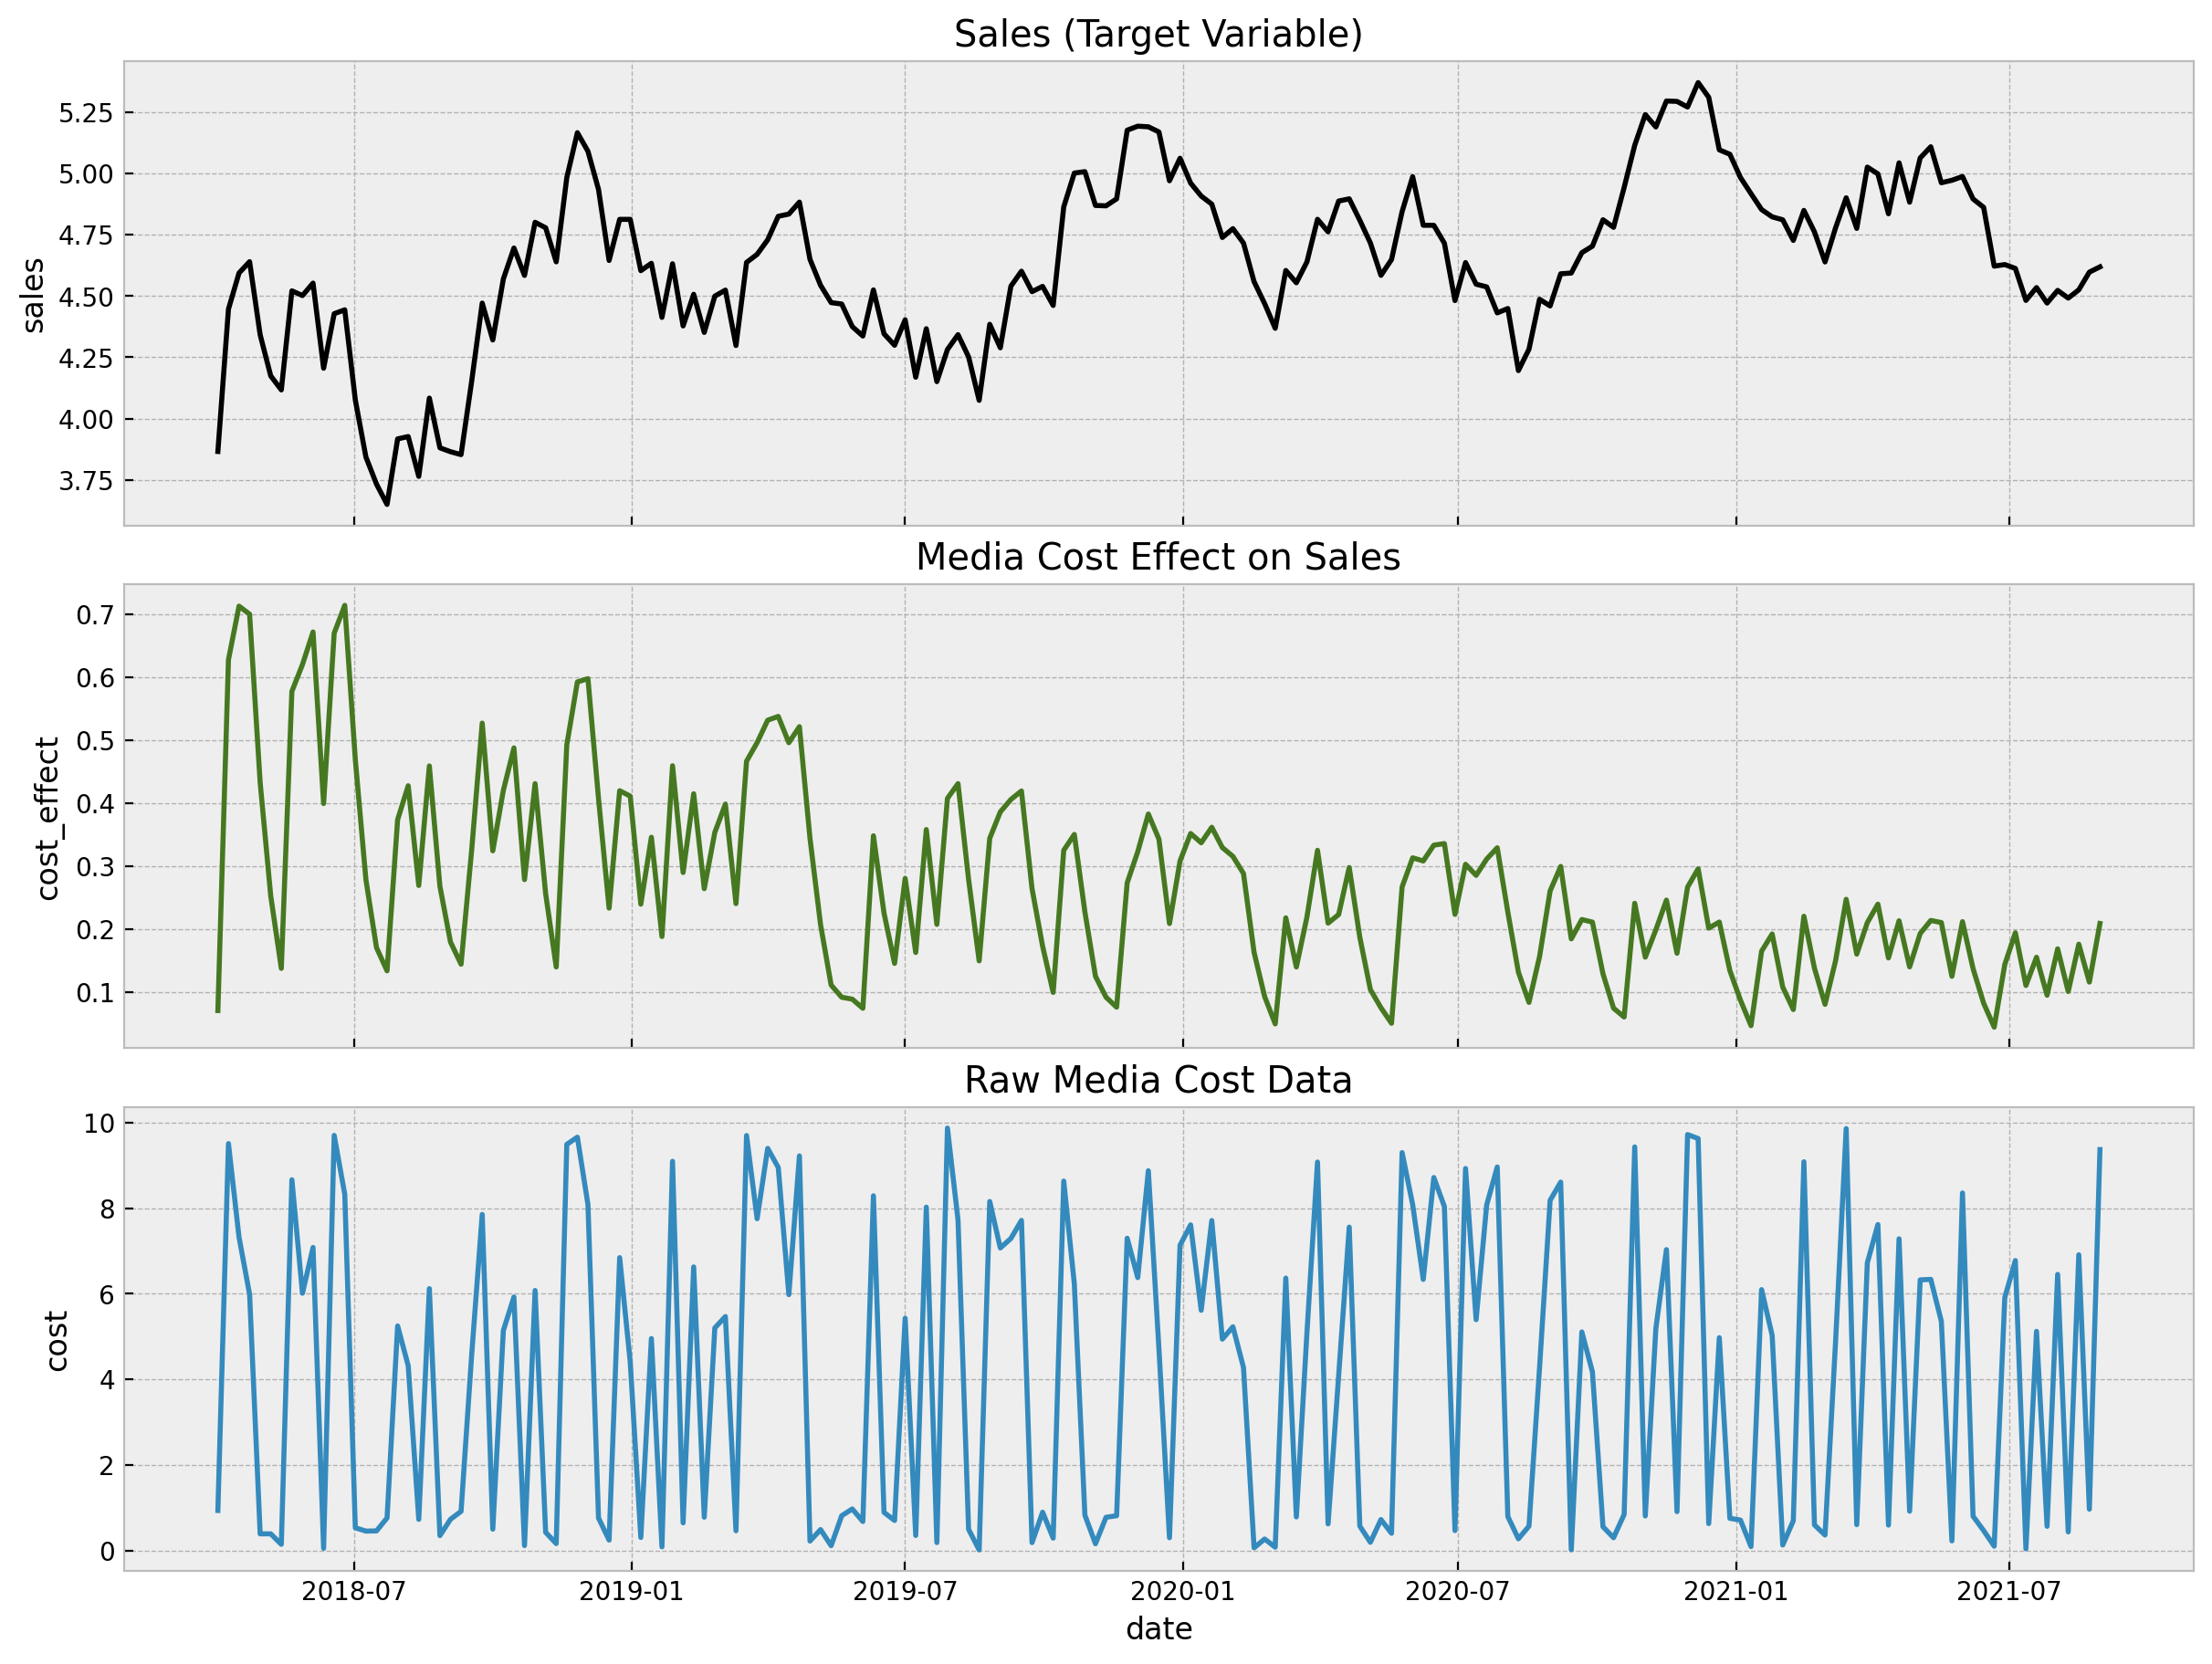

In [3]:
fig, ax = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(12, 9),
    sharex=True,
    sharey=False,
    layout="constrained"
)
sns.lineplot(x="date", y="sales", color="black", data=data_df, ax=ax[0])
ax[0].set(title="Sales (Target Variable)")
sns.lineplot(x="date", y="cost_effect", color="C3", data=data_df, ax=ax[1])
ax[1].set(title="Media Cost Effect on Sales")
sns.lineplot(x="date", y="cost", data=data_df, ax=ax[2])
ax[2].set(title="Raw Media Cost Data");

1. The first plot is our target variable `sales`, which can represent sales data, for example.
2. The second plot is the `cost_effect` variable, which is the simulated effect of the media spent variable `cost` on the variable `sales`. **In practice we do not know `cost_effect`. We would like to infer it from the data!**
3. The last plot represent the input data `cost` which is something we have control of.

Note that the variable `sales` has a trend and strong (additive) yearly seasonality components.

## Features

We of course do not want to use the trend os seasonal components from  the `data_df` dataframe, as the whole point id to learn them tom the data. Hence, let us keep the variables we would actually have in when developing the model.

In [4]:
columns_to_keep = ["index", "date", "year", "month", "dayofyear", "cost", "sales"]

df = data_df[columns_to_keep].copy()

Next, we generate input features to model the trend and seasonal components. We follow the strategy presented in the very comprehensive post [Air passengers - Prophet-like model](https://docs.pymc.io/en/stable/pymc-examples/examples/time_series/Air_passengers-Prophet_with_Bayesian_workflow.html) from the [`pymc-examples`](https://docs.pymc.io/en/stable/pymc-examples/README.html) repository (please check it out!).

In [11]:
date = df["date"].to_numpy()
date_index = df.index
sales = df["sales"].to_numpy()
cost = df["cost"].to_numpy()
t = t.values
n_obs = sales.size

### Scaling

We scale both the target variable `sales` and the channel input `cost` using a [`MaxAbsScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html). During the whole analysis we carefully study the effect of these scalers and describe how to recover back the predictions and effects in the original scale.

**Remark:** One would be tempted to use a [`MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) here. However, this would lead to a problem when computing the
(m)ROAS (see more details below). The reason is that for the ROAS computation we want to set the media cost to $0$ (in the raw data
scale!) and generate in-sample predictions. The problem comes when the media data never reaches $0$. In this case,
when using a [`MaxAbsScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html), the zero value of the transformed variable represents the minimum value of the
original variable. Hence, when setting the media cost to $0$, the transformed variable would be less than zero.
This itself not a problem, but since most og the times we are restricting the regression coefficients of the
media variables to be positive (e.g. via a [`pm.HalfNormal`](https://www.pymc.io/projects/docs/en/latest/api/distributions/generated/pymc.HalfNormal.html) prior) then the media contribution of in the ROAS computation would be negative! This of course does not make sense. Hence, we use a [`MaxAbsScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) here, which
ensures that the zero in the transformed variable is the zero in the original variable.

In [13]:
sales_scaler = MaxAbsScaler()
sales_scaler.fit(sales.reshape(-1, 1))
sales_scaled = sales_scaler.transform(sales.reshape(-1, 1)).flatten()

cost_scaler = MaxAbsScaler()
cost_scaler.fit(cost.reshape(-1, 1))
cost_scaled = cost_scaler.transform(cost.reshape(-1, 1)).flatten()

## Models

In this section we fit $3$ models, from simpler to complex:
1. **Base Model:** We fit a linear regression model with a single regressor `cost` and controlling from trend ans seasonality.

2. **Adstock-Saturation Model:** We use the same model structure as the base model but we now apply the (geometric) adstock and saturation transformations to the `cost` variable. We **do not** set a value for $\alpha$ and $\lambda$ as we learn them from the data. We do fix the variable $\ell=12$ of the adstock transformation.

3. **Adstock-Saturation-Diminishing Returns Model:** We use the same model structure as the Adstock-Saturation model but we allow a time-varying coefficient for (the transformed) `cost` by modeling it as a gaussian random walk.

Here are some comments on the models:

- We use a [`pm.HalfNormal`](https://www.pymc.io/projects/docs/en/latest/api/distributions/generated/pymc.HalfNormal.html) distribution for the media coefficients to ensure they are positive.
- We use a [`pm.Laplace`](https://docs.pymc.io/en/latest/api/distributions/generated/pymc.Laplace.html) distribution fot the fourier coefficient to add certain regularization (these features can easily lead to an overfit).
- For the likelihood function we use a [`pm.StudentT`](https://www.pymc.io/projects/docs/en/latest/api/distributions/generated/pymc.StudentT.html) distribution which is most robust against outliers.

### Base Model

Let us start by defining the structure of the base model, which is the be the core of the models to come.

- Model Specification

In [91]:
coords = {"date": date}

with pm.Model(coords=coords) as base_model:
    # --- data containers ---
    cost_scaled_ = pm.MutableData(name="cost_scaled", value=cost_scaled, dims="date")

    # --- priors ---
    ## intercept
    a = pm.Normal(name="a", mu=0, sigma=4)
    ## regressor
    b_cost = pm.HalfNormal(name="b_cost", sigma=2)
    ## standard deviation of the normal likelihood
    sigma = pm.HalfNormal(name="sigma", sigma=0.5)
    # degrees of freedom of the t distribution
    nu = pm.Gamma(name="nu", alpha=25, beta=2)

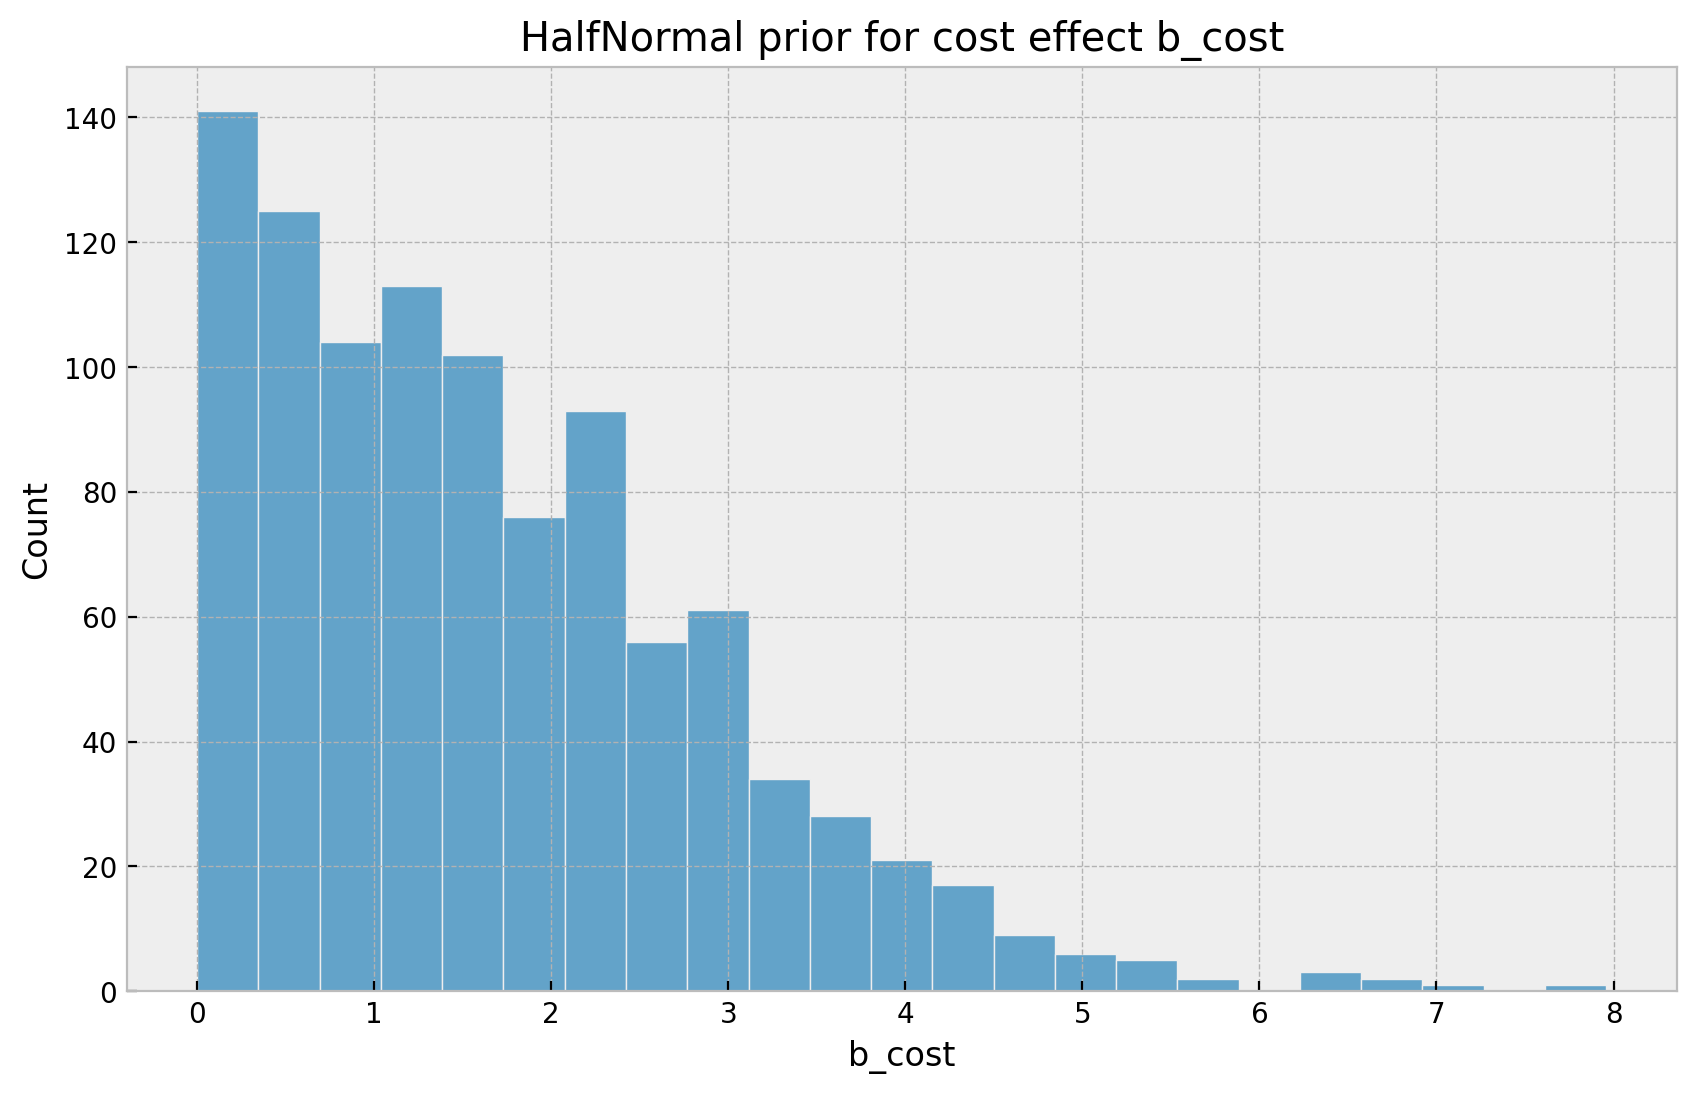

In [92]:
sns.histplot(pm.draw(b_cost, draws=1000));
plt.title("HalfNormal prior for cost effect b_cost"); plt.xlabel("b_cost");

Sampling: [a, b_cost, likelihood, nu, sigma]


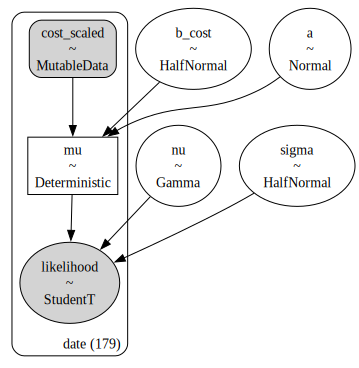

In [93]:
with base_model:
    # --- model parametrization ---
    mu = pm.Deterministic(name="mu", var=a + b_cost * cost_scaled_, dims="date")

    # --- likelihood ---
    pm.StudentT(name="likelihood", nu=nu, mu=mu, sigma=sigma, observed=sales_scaled, dims="date")

    # --- prior samples ---
    base_model_prior_predictive = pm.sample_prior_predictive()

pm.model_to_graphviz(model=base_model)

In [17]:
# Simulate data for specific parameter values
fixed_parameters = {
    "betas": [-2, -1, 0, 1, 2],
    "sigma": 0.5,
}

with pm.do(generative_model, fixed_parameters) as synthetic_model:
    synthetic_sales = pm.draw(synthetic_model["likelihood"])
    

KeyError: 'betas'

### Posterior sampling

In [95]:
with base_model:
    base_model_trace = pm.sample(
        nuts_sampler="numpyro",
        draws=6000,
        chains=4,
        idata_kwargs={"log_likelihood": True},
        progressbar=False,
    )
    base_model_posterior_predictive = pm.sample_posterior_predictive(
        trace=base_model_trace
    )

Compiling...
Compilation time = 0:00:00.473012
Sampling...
Sampling time = 0:00:01.754561
Transforming variables...
Transformation time = 0:00:00.047405
Computing Log Likelihood...
Log Likelihood time = 0:00:00.148265
Sampling: [likelihood]


### Model checking

In [96]:
az.summary(
    data=base_model_trace,
    var_names=["a", "b_cost", "sigma", "nu"],
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
a        0.843  0.007   0.829    0.856      0.000    0.000   13465.0   
b_cost   0.052  0.013   0.028    0.076      0.000    0.000   13145.0   
sigma    0.057  0.003   0.051    0.063      0.000    0.000   18310.0   
nu      12.990  2.469   8.529   17.652      0.018    0.012   19130.0   

        ess_tail  r_hat  
a        14462.0    1.0  
b_cost   10940.0    1.0  
sigma    16247.0    1.0  
nu       15061.0    1.0

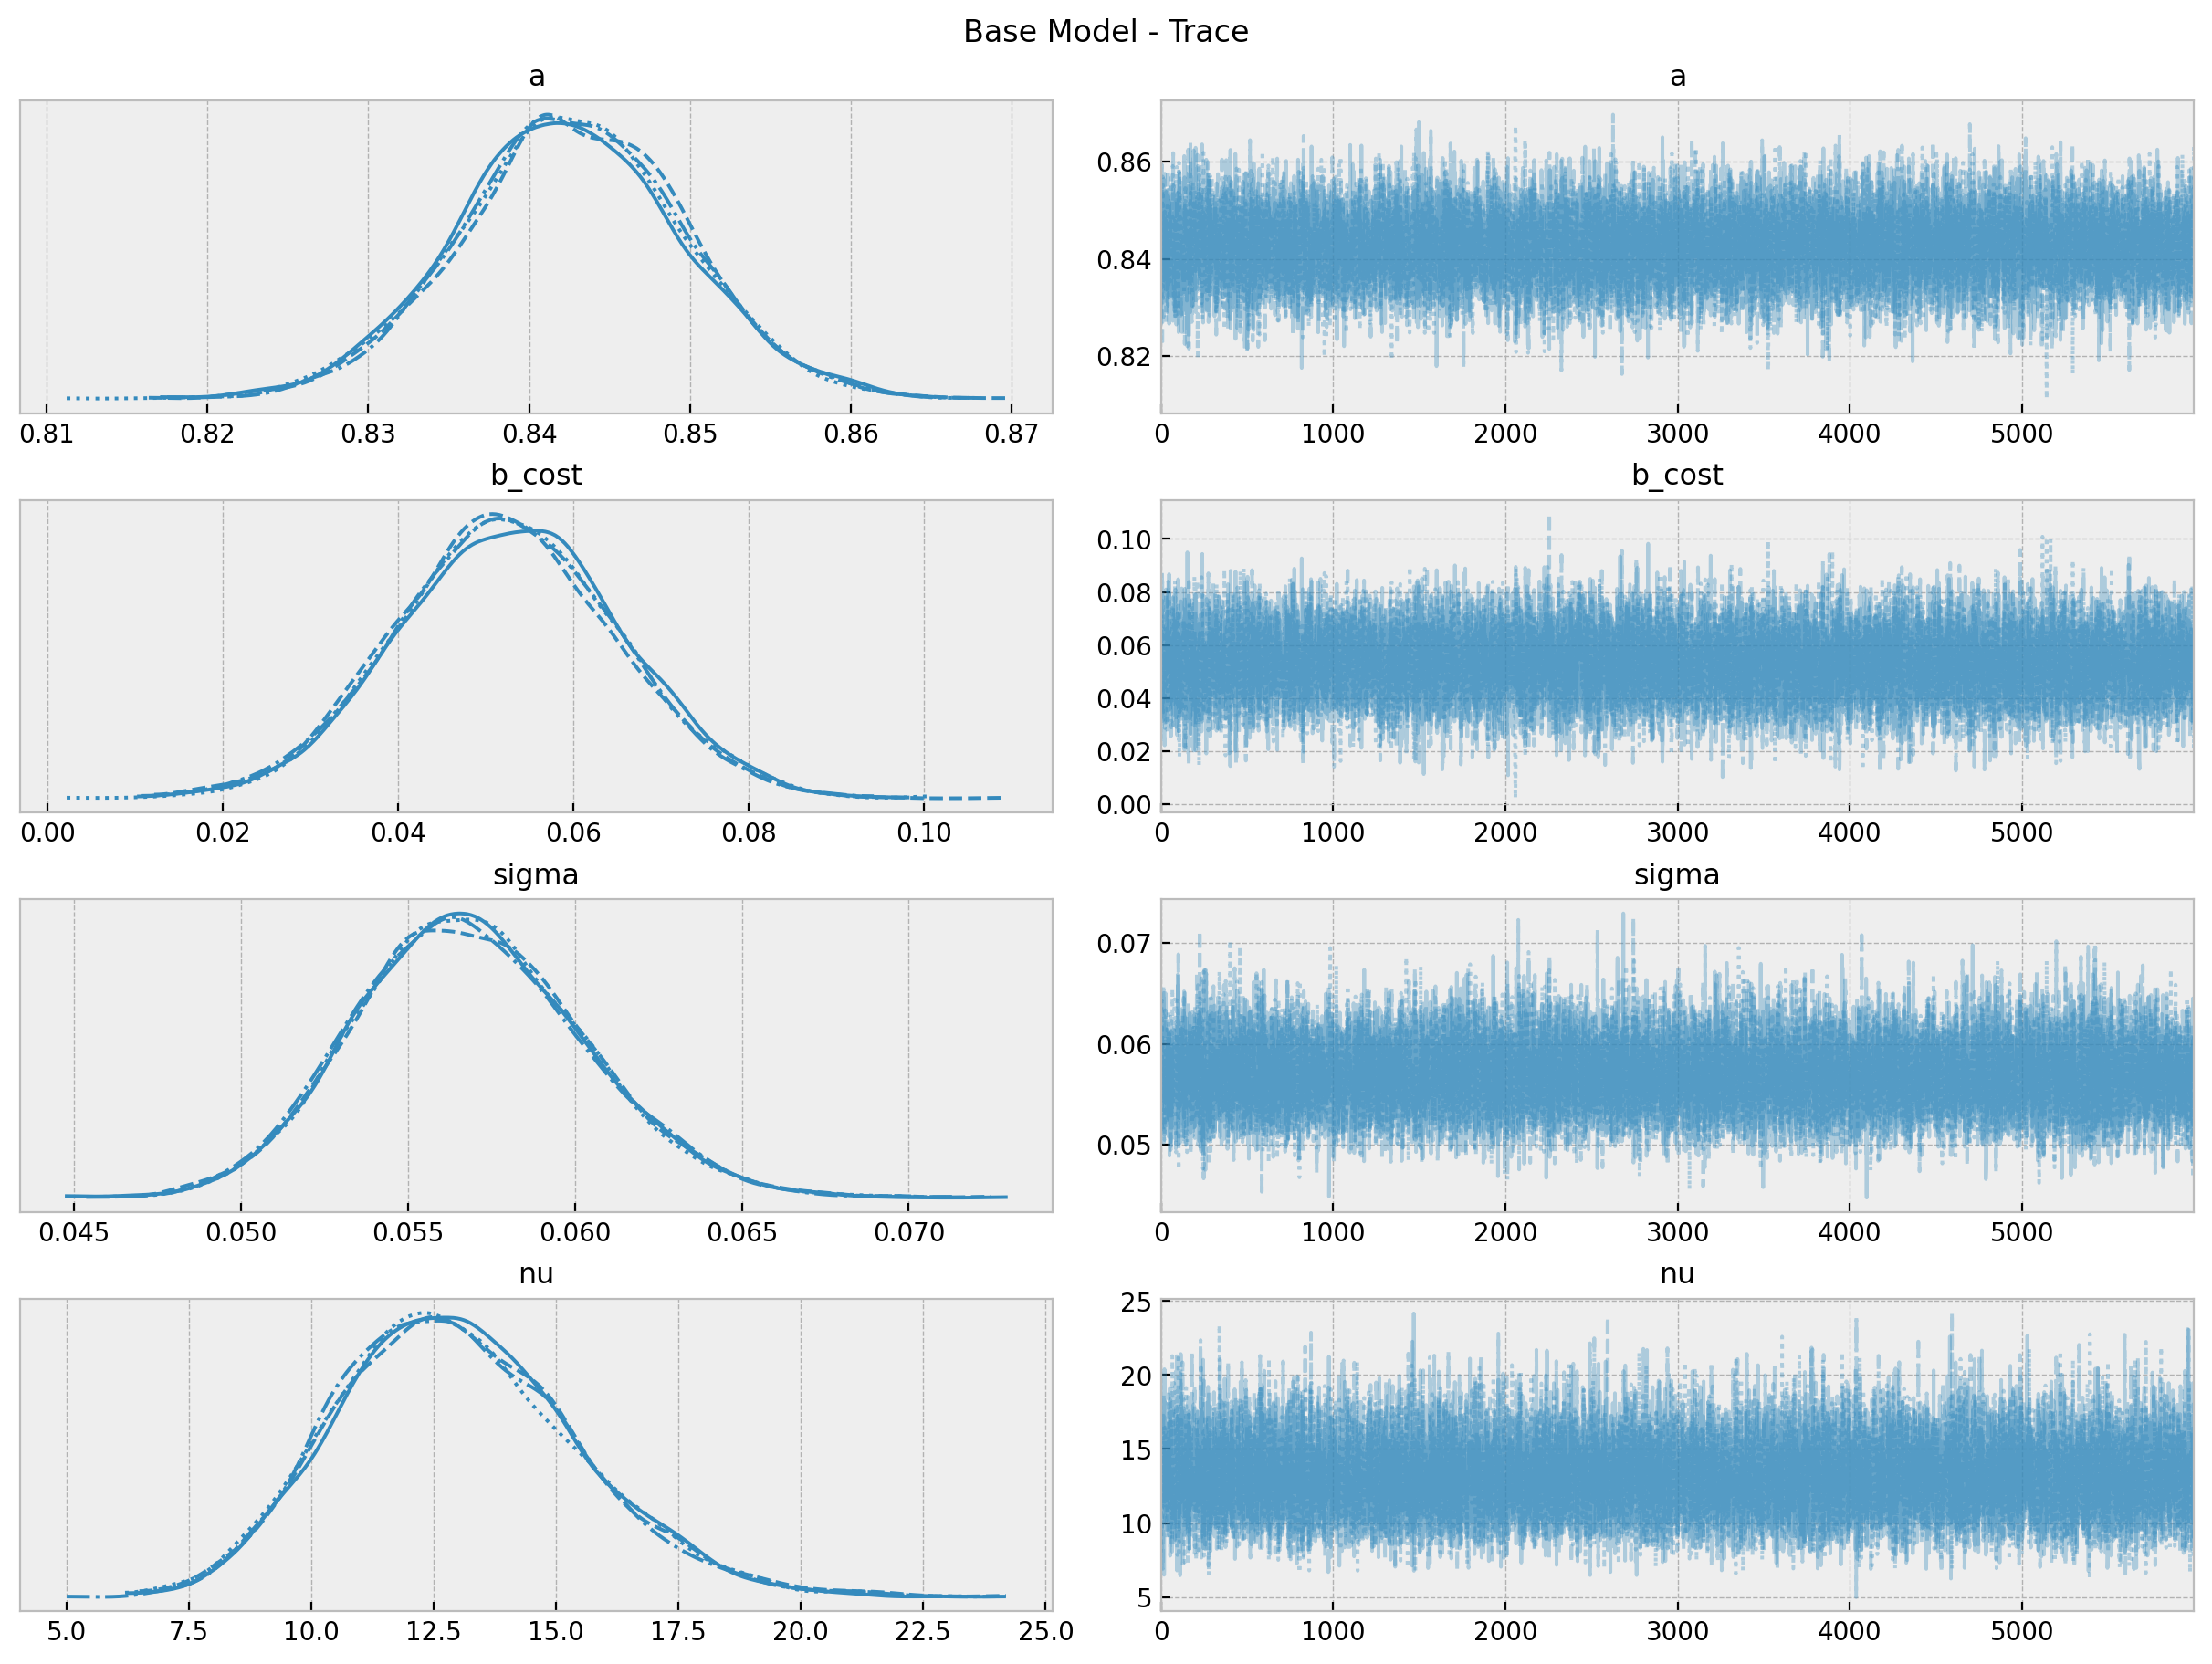

In [97]:
axes = az.plot_trace(
    data=base_model_trace,
    var_names=["a", "b_cost", "sigma", "nu"],
    compact=True,
    backend_kwargs={
        "figsize": (12, 9),
        "layout": "constrained"
    },
)
fig = axes[0][0].get_figure()
fig.suptitle("Base Model - Trace");

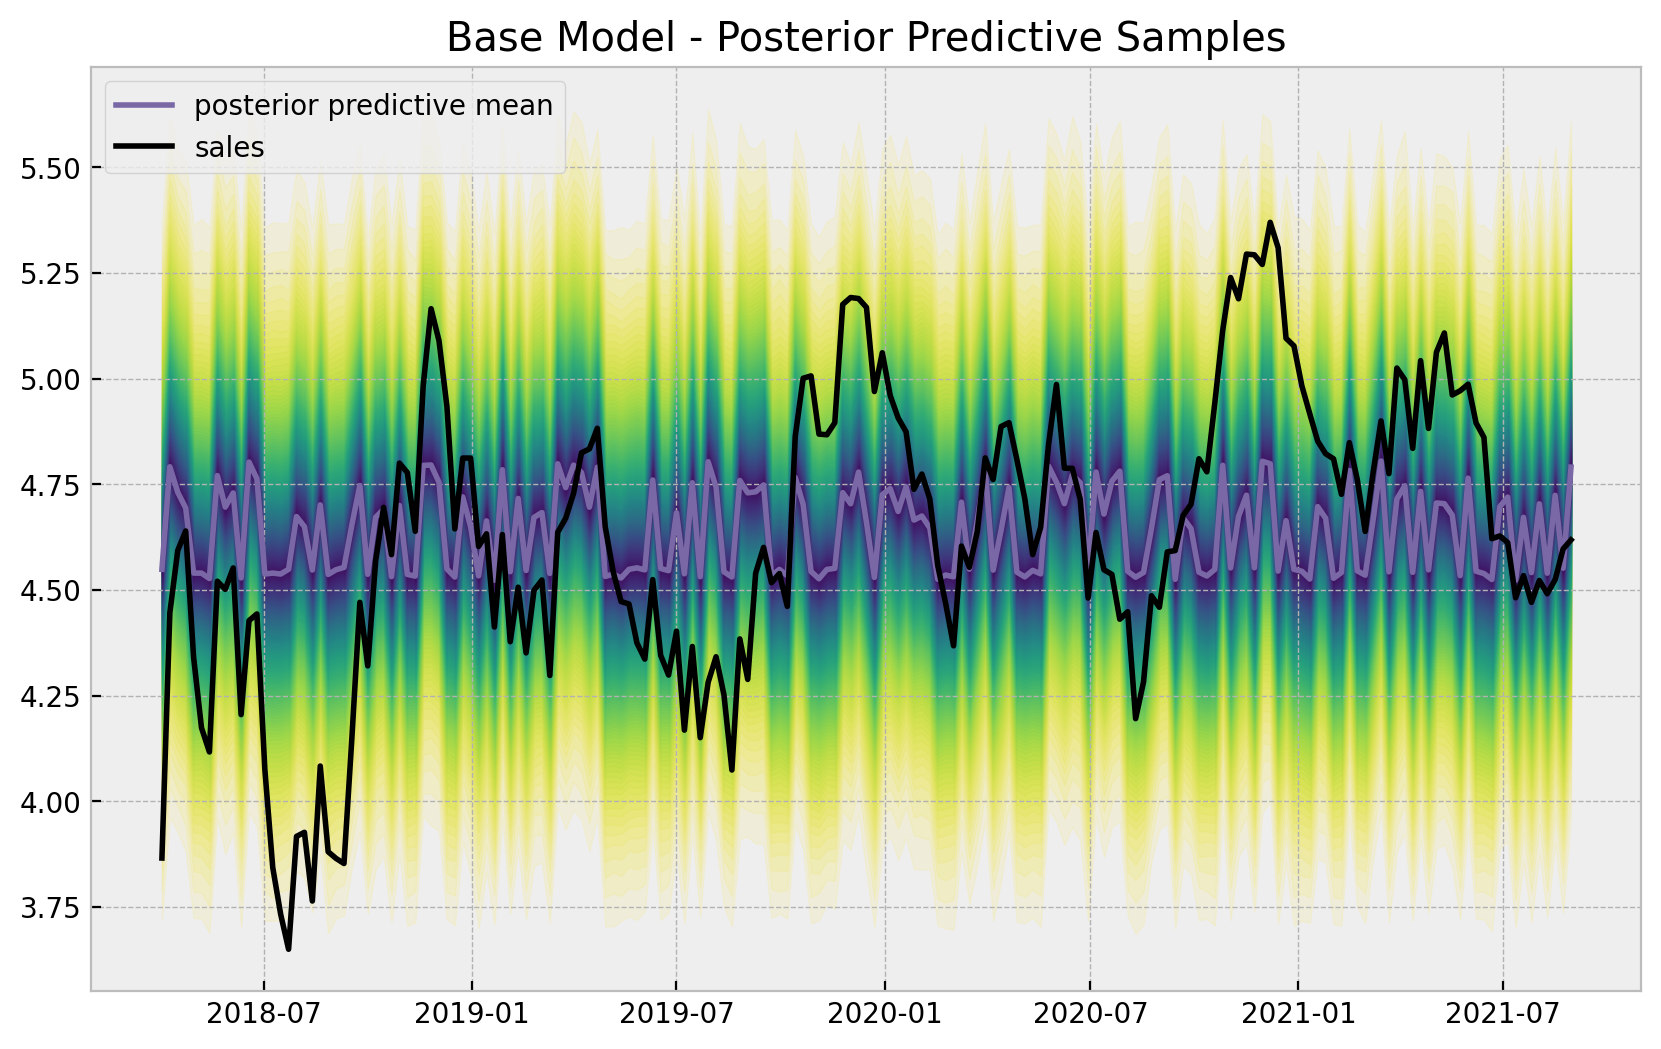

In [49]:
posterior_predictive_likelihood = az.extract(
    data=base_model_posterior_predictive,
    group="posterior_predictive",
    var_names="likelihood",
)

posterior_predictive_likelihood_inv = sales_scaler.inverse_transform(
    X=posterior_predictive_likelihood
)

fig, ax = plt.subplots()

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(posterior_predictive_likelihood_inv, p, axis=1)
    lower = np.percentile(posterior_predictive_likelihood_inv, 100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(
        x=date,
        y1=upper,
        y2=lower,
        color=cmap(color_val),
        alpha=0.1,
    )

sns.lineplot(
    x=date,
    y=posterior_predictive_likelihood_inv.mean(axis=1),
    color="C2",
    label="posterior predictive mean",
    ax=ax,
)
sns.lineplot(
    x=date,
    y=sales,
    color="black",
    label="sales",
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="Base Model - Posterior Predictive Samples");

## Model improvement: Trend + Seasonality model

Our model is not doing a great job reproducing the data. Two critical components that are missing are a linear trend as well as seasonality.

### Trend

For the trend component we simply use a linear feature (which we scale  between $0$ and $1$).

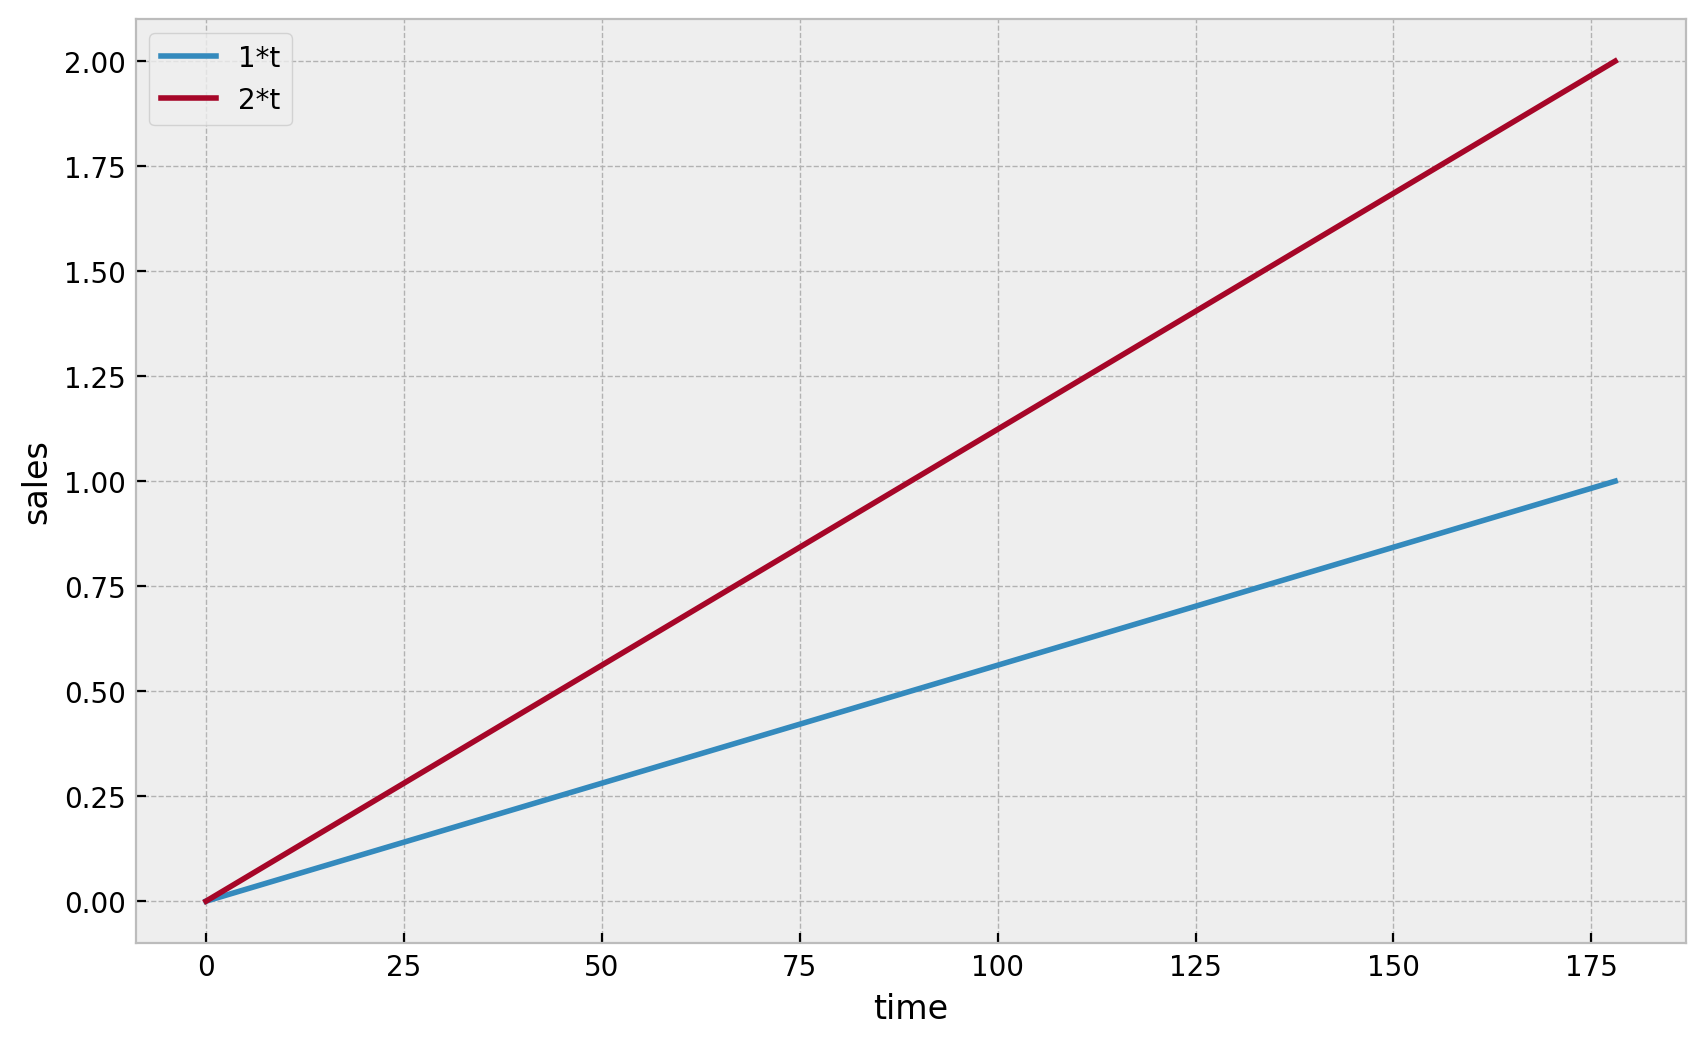

In [53]:
t = (df.index - df.index.min()) / (df.index.max() - df.index.min())
plt.plot(t, label="1*t"); plt.plot(2*t, label="2*t"); plt.xlabel("time"); plt.ylabel("sales"); plt.legend();

### Seasonality

To model the seasonality, we use [Fourier modes](https://en.wikipedia.org/wiki/Fourier_series) (similarly as in Prophet or Orbit).

In [6]:
n_order = 7
periods = df["dayofyear"] / 365.25
fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)

We can see how these cyclic features look like:

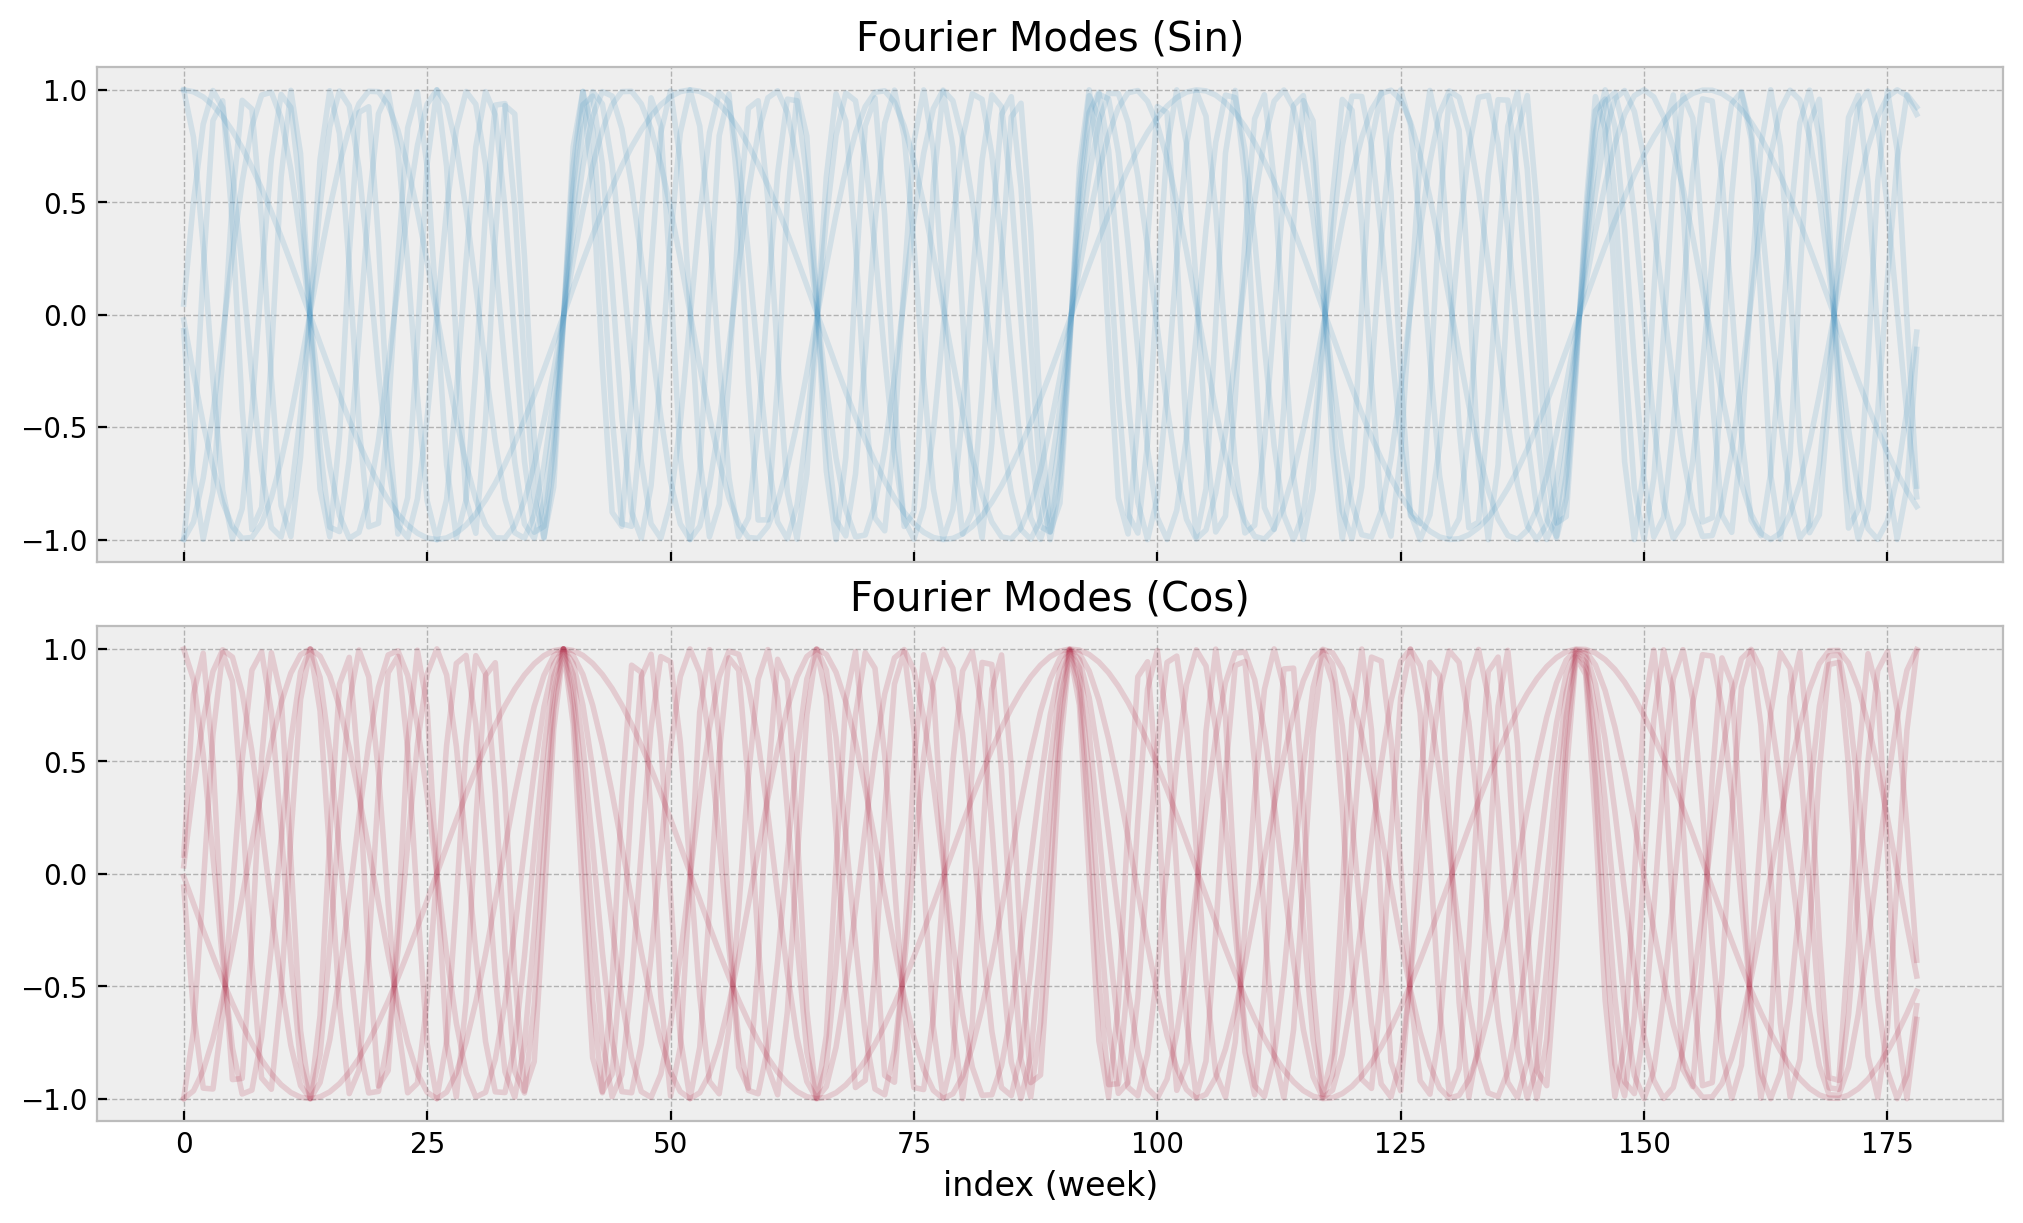

In [7]:
fig, ax = plt.subplots(nrows=2, sharex=True, layout="constrained")
fourier_features.filter(like="sin").plot(color="C0", alpha=0.15, ax=ax[0])
ax[0].get_legend().remove()
ax[0].set(title="Fourier Modes (Sin)", xlabel="index (week)")
fourier_features.filter(like="cos").plot(color="C1", alpha=0.15, ax=ax[1])
ax[1].get_legend().remove()
ax[1].set(title="Fourier Modes (Cos)", xlabel="index (week)");

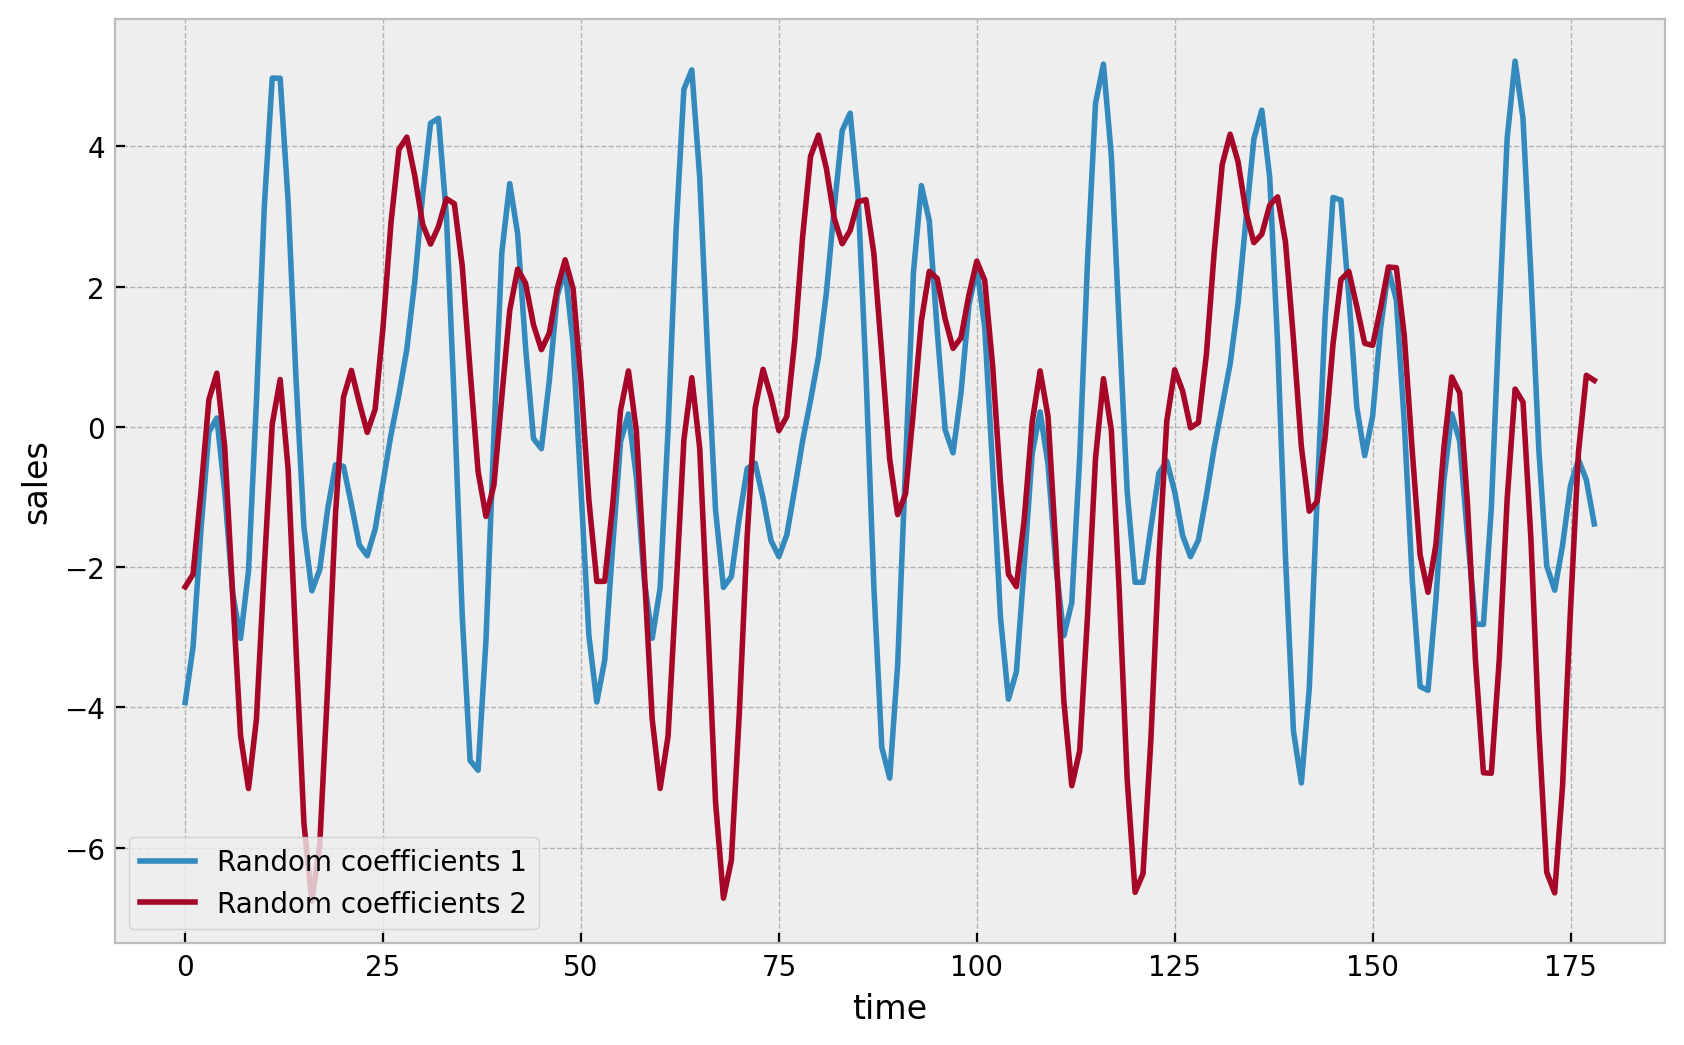

In [74]:
seasonal_pattern1 = fourier_features @ np.random.randn(len(fourier_features.columns))
plt.plot(seasonal_pattern1, label="Random coefficients 1"); 
seasonal_pattern2 = fourier_features @ np.random.randn(len(fourier_features.columns))
plt.plot(seasonal_pattern2, label="Random coefficients 2"); 

plt.xlabel("time"); plt.ylabel("sales"); plt.legend();

Sampling: [a, b_cost, b_fourier, b_trend, likelihood, nu, sigma]


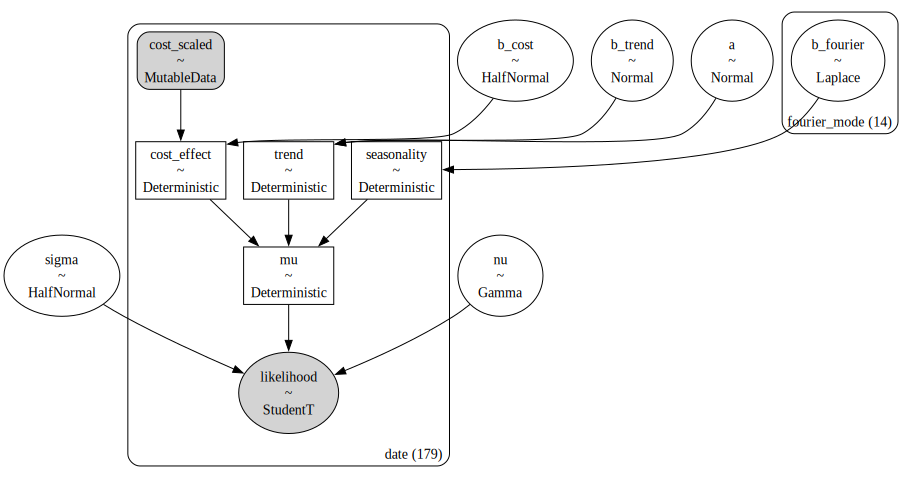

In [27]:
coords = {"date": date, "fourier_mode": np.arange(2 * n_order)}

with pm.Model(coords=coords) as trend_seasonal_model:
    # --- coords ---
    trend_seasonal_model.add_coord(name="dat", values=date, mutable=True)
    trend_seasonal_model.add_coord(name="fourier_mode", values=np.arange(2 * n_order), mutable=False)

    # --- data containers ---
    cost_scaled_ = pm.MutableData(name="cost_scaled", value=cost_scaled, dims="date")

    # --- priors ---
    ## intercept
    a = pm.Normal(name="a", mu=0, sigma=4)
    ## trend
    b_trend = pm.Normal(name="b_trend", mu=0, sigma=2)
    ## seasonality
    b_fourier = pm.Laplace(name="b_fourier", mu=0, b=2, dims="fourier_mode")
    ## regressor
    b_cost = pm.HalfNormal(name="b_cost", sigma=2)
    ## standard deviation of the normal likelihood
    sigma = pm.HalfNormal(name="sigma", sigma=0.5)
    # degrees of freedom of the t distribution
    nu = pm.Gamma(name="nu", alpha=25, beta=2)

    # --- model parametrization ---
    trend = pm.Deterministic(name="trend", var=a + b_trend * t, dims="date")
    seasonality = pm.Deterministic(
        name="seasonality", var=fourier_features @ b_fourier, dims="date"
    )
    cost_effect = pm.Deterministic(name="cost_effect", var=b_cost * cost_scaled_, dims="date")
    mu = pm.Deterministic(name="mu", var=trend + seasonality + cost_effect, dims="date")

    # --- likelihood ---
    pm.StudentT(name="likelihood", nu=nu, mu=mu, sigma=sigma, observed=sales_scaled, dims="date")

    # --- prior samples ---
    trend_seasonal_model_prior_predictive = pm.sample_prior_predictive()

pm.model_to_graphviz(model=trend_seasonal_model)

In [83]:
coords = {"date": date, "fourier_mode": np.arange(2 * n_order)}

with pm.Model(coords=coords) as trend_seasonal_model:
    # --- data containers ---
    cost_scaled_ = pm.MutableData(name="cost_scaled", value=cost_scaled, dims="date")

    # --- priors ---
    ## intercept
    a = pm.Normal(name="a", mu=0, sigma=4)
    ## trend
    b_trend = pm.Normal(name="b_trend", mu=0, sigma=2)
    ## seasonality
    b_fourier = pm.Laplace(name="b_fourier", mu=0, b=2, dims="fourier_mode")
    ## regressor
    b_cost = pm.HalfNormal(name="b_cost", sigma=2)
    ## standard deviation of the normal likelihood
    sigma = pm.HalfNormal(name="sigma", sigma=0.5)
    # degrees of freedom of the t distribution
    nu = pm.Gamma(name="nu", alpha=25, beta=2)

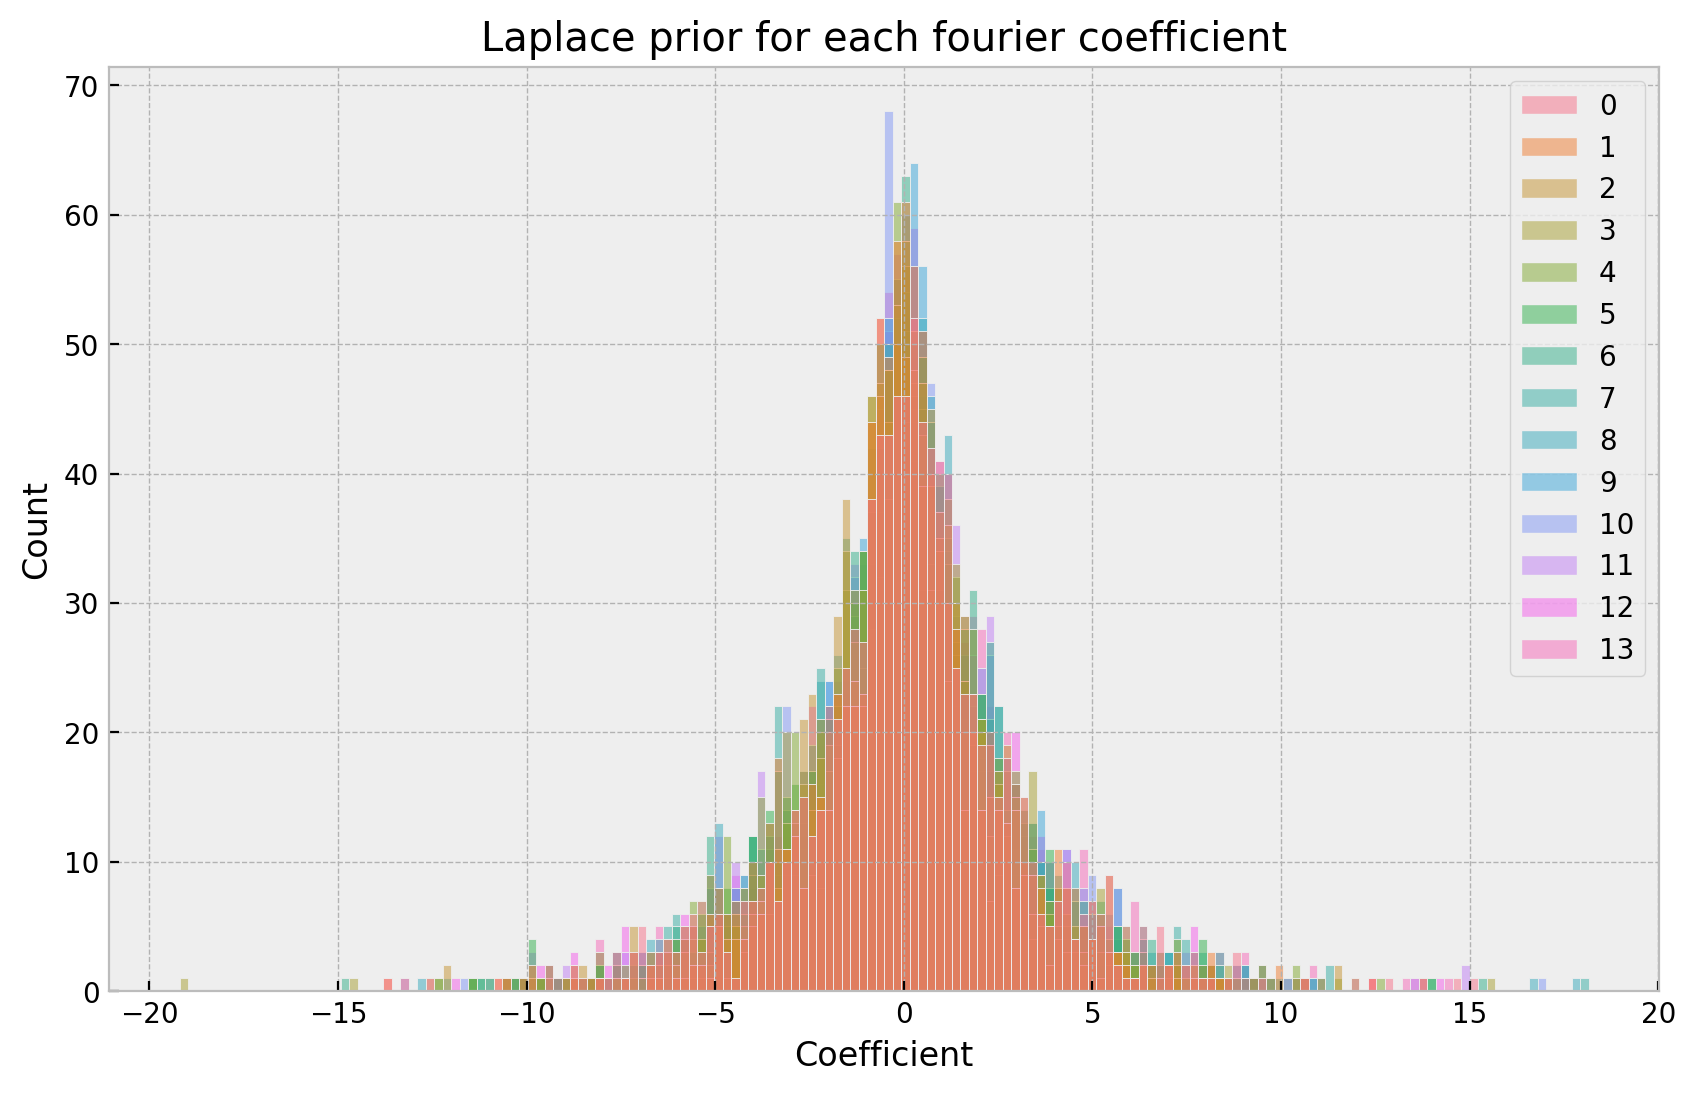

In [84]:
sns.histplot(pm.draw(b_fourier, draws=1000));
plt.title("Laplace prior for each fourier coefficient"); plt.xlabel("Coefficient");

In [85]:
with trend_seasonal_model:
    # --- model parameterization ---
    trend = pm.Deterministic(name="trend", var=a + b_trend * t, dims="date")
    seasonality = pm.Deterministic(
        name="seasonality", var=fourier_features @ b_fourier, dims="date"
    )
    cost_effect = pm.Deterministic(name="cost_effect", var=b_cost * cost_scaled_, dims="date")

    # Putting it all together
    mu = pm.Deterministic(name="mu", var=trend + seasonality + cost_effect, dims="date")

    # --- likelihood ---
    pm.StudentT(name="likelihood", nu=nu, mu=mu, sigma=sigma, observed=sales_scaled, dims="date")

    # --- prior samples ---
    trend_seasonal_model_prior_predictive = pm.sample_prior_predictive()

pm.model_to_graphviz(model=trend_seasonal_model)

ValueError: setting an array element with a sequence.

- Prior Predictive Samples

Let us start by sampling from the model before looking into the data:

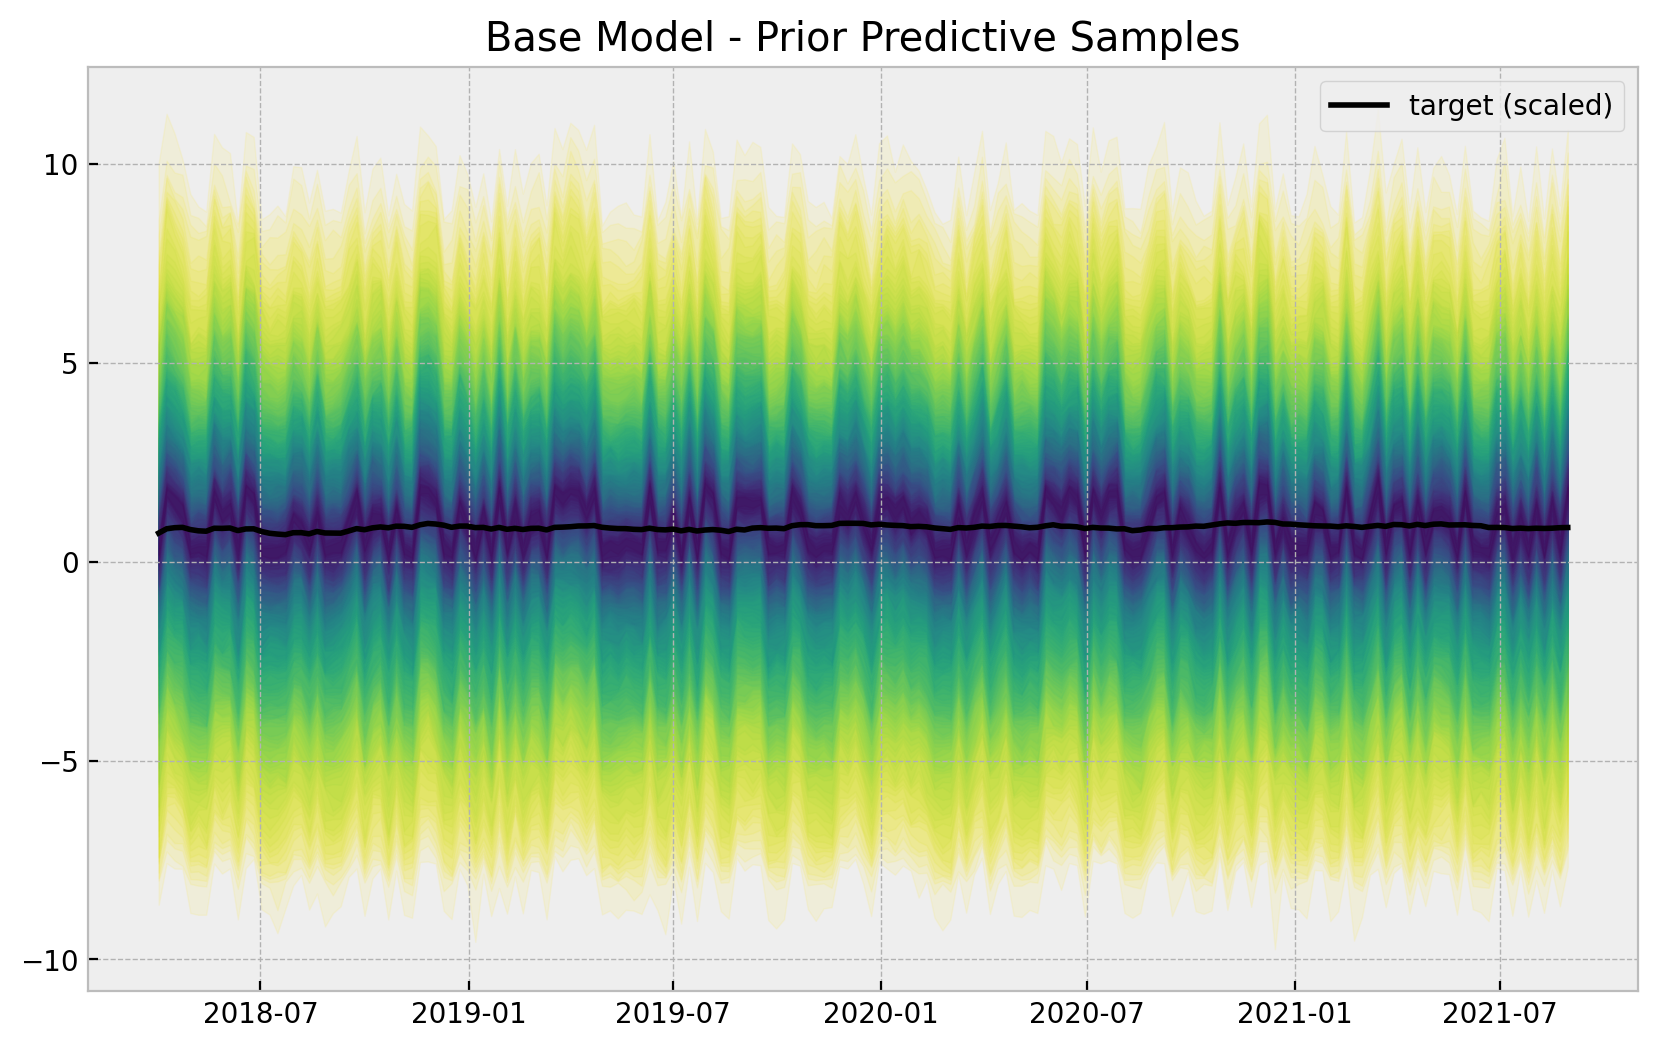

In [41]:
# useful way to color the distribution
palette = "viridis_r"
cmap = plt.get_cmap(palette)
percs = np.linspace(51, 99, 100)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))


fig, ax = plt.subplots()

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(trend_seasonal_model_prior_predictive.prior_predictive["likelihood"], p, axis=1)
    lower = np.percentile(
        trend_seasonal_model_prior_predictive.prior_predictive["likelihood"], 100 - p, axis=1
    )
    color_val = colors[i]
    ax.fill_between(
        x=date,
        y1=upper.flatten(),
        y2=lower.flatten(),
        color=cmap(color_val),
        alpha=0.1,
    )

sns.lineplot(x=date, y=sales_scaled, color="black", label="target (scaled)", ax=ax)
ax.legend()
ax.set(title="Base Model - Prior Predictive Samples");

The priors do constrain the range of the generated time series. Nevertheless, they are not too restrictive.

**Remark:** Note that the prior predictive shows the possibility of having *negative sales* which makes no sense. A common approach is to model the logarithm of the sales instead. We do not do this here for the sake of simplicity (specially when interpreting the results).

- Fit Model

In [42]:
with trend_seasonal_model:
    trend_seasonal_model_trace = pm.sample(
        nuts_sampler="numpyro",
        draws=6000,
        chains=4,
        idata_kwargs={"log_likelihood": True},
    )
    trend_seasonal_model_posterior_predictive = pm.sample_posterior_predictive(
        trace=trend_seasonal_model_trace
    )

Compiling...
Compilation time = 0:00:00.809261
Sampling...
Compiling.. :   0%|                                                                                                                                      | 0/7000 [00:00<?, ?it/s]

  0%|                                                                                                                                                    | 0/7000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                                                                      | 0/7000 [00:00<?, ?it/s]


  0%|                                                                                                                                                    | 0/7000 [00:00<?, ?it/s]


Running chain 0:   0%|                                                                                                                                   | 0/7000 [00:01<?, ?it/s]


Running chain 3:   0%|                

**Remark:** We add the argument `idata_kwargs={"log_likelihood": True}` since we want to compare various models using [`az.compare`](https://python.arvicost.org/en/latest/api/generated/arvicost.compare.html). See [this issue](https://github.com/arviz-devs/arviz/issues/2155) for more details.

- Model Diagnostics

In [43]:
az.summary(
    data=trend_seasonal_model_trace,
    var_names=["a", "b_trend", "b_cost", "sigma", "nu"],
)

KeyError: 'var names: "[\'b_trend\'] are not present" in dataset'

/Users/twiecki/micromamba/envs/pymc5/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


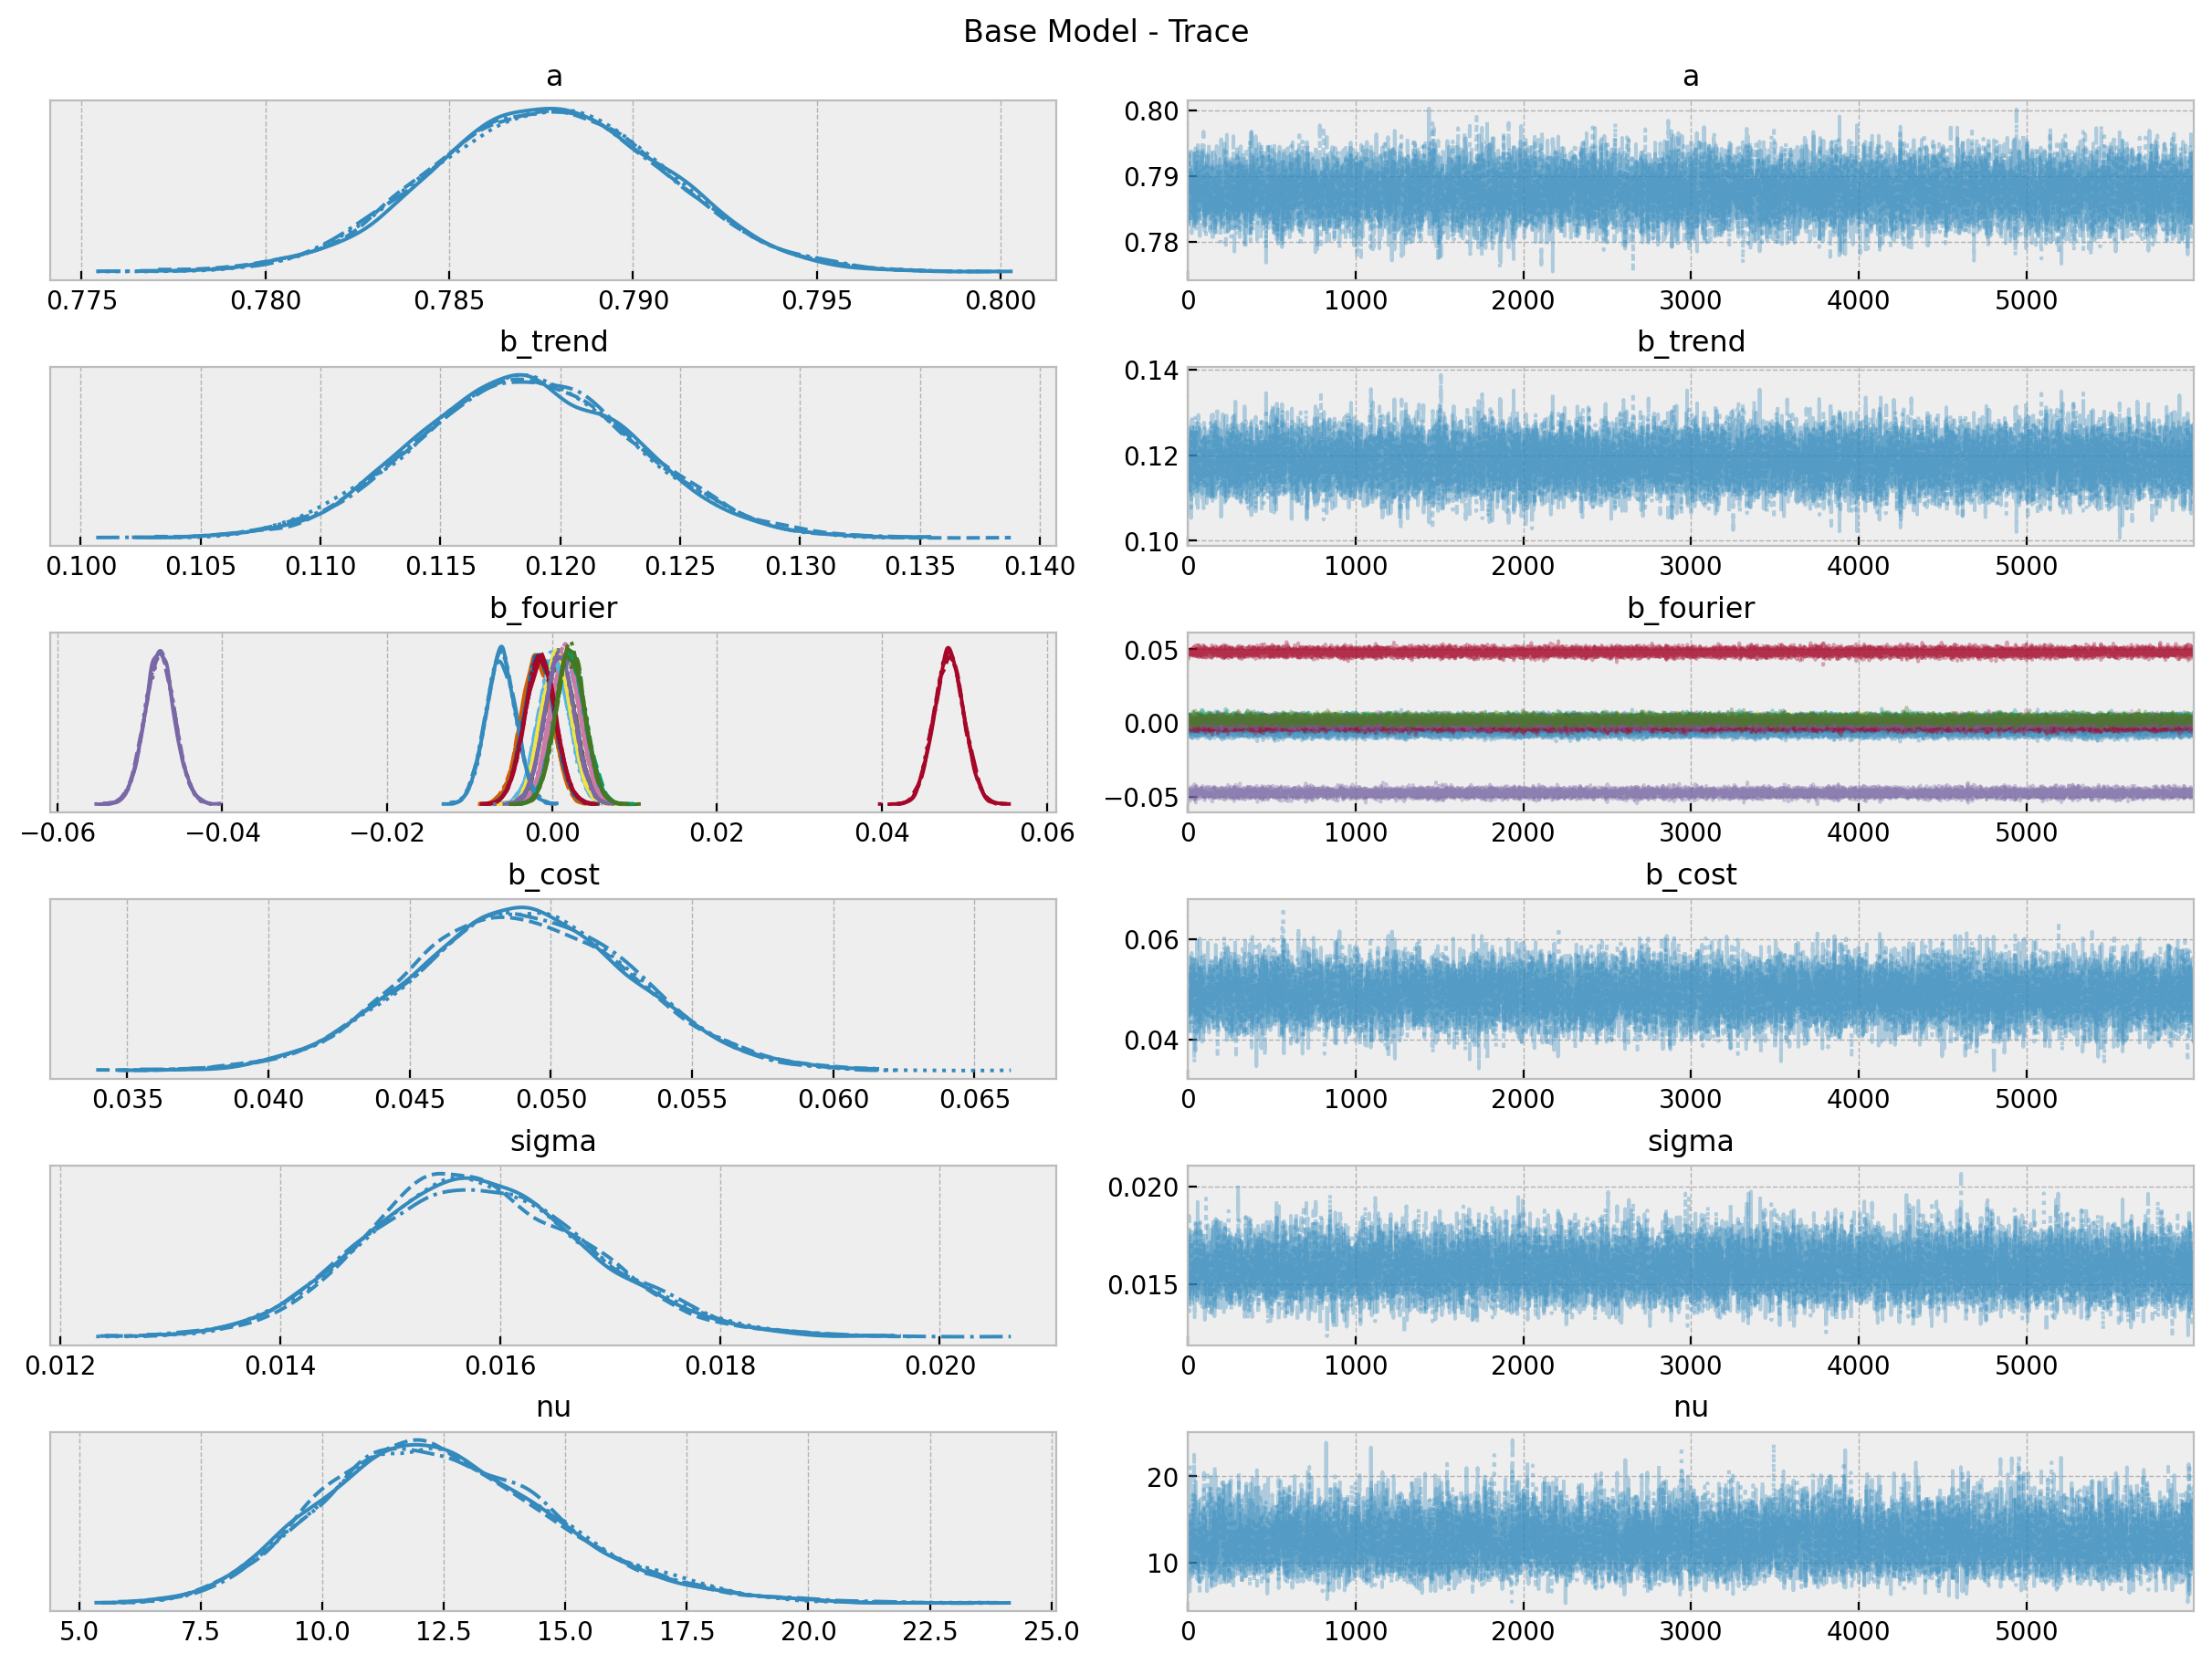

In [32]:
axes = az.plot_trace(
    data=trend_seasonal_model_trace,
    var_names=["a", "b_trend", "b_fourier", "b_cost", "sigma", "nu"],
    compact=True,
    backend_kwargs={
        "figsize": (12, 9),
        "layout": "constrained"
    },
)
fig = axes[0][0].get_figure()
fig.suptitle("Base Model - Trace");

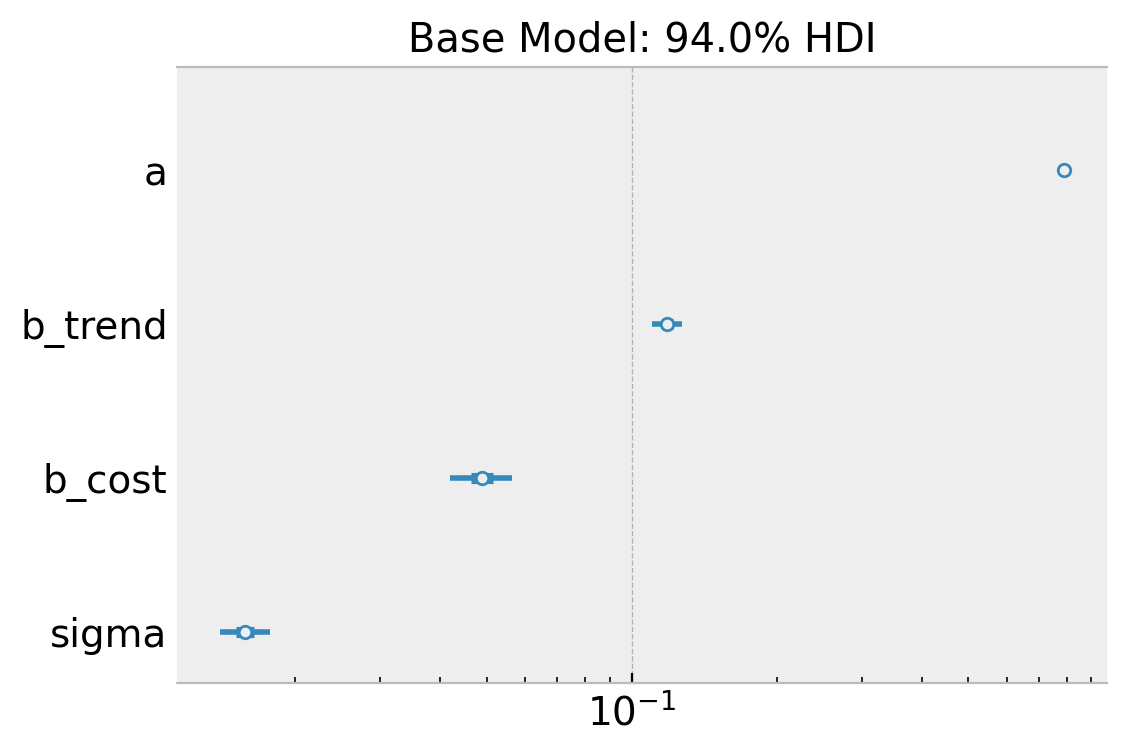

In [33]:
fig, ax = plt.subplots(figsize=(6, 4))
az.plot_forest(
    data=trend_seasonal_model_trace,
    var_names=["a", "b_trend", "b_cost", "sigma"],
    combined=True,
    ax=ax
)
ax.set(
    title="Base Model: 94.0% HDI",
    xscale="log"
);

Overall, the model looks ok!

- Posterior Predictive Samples

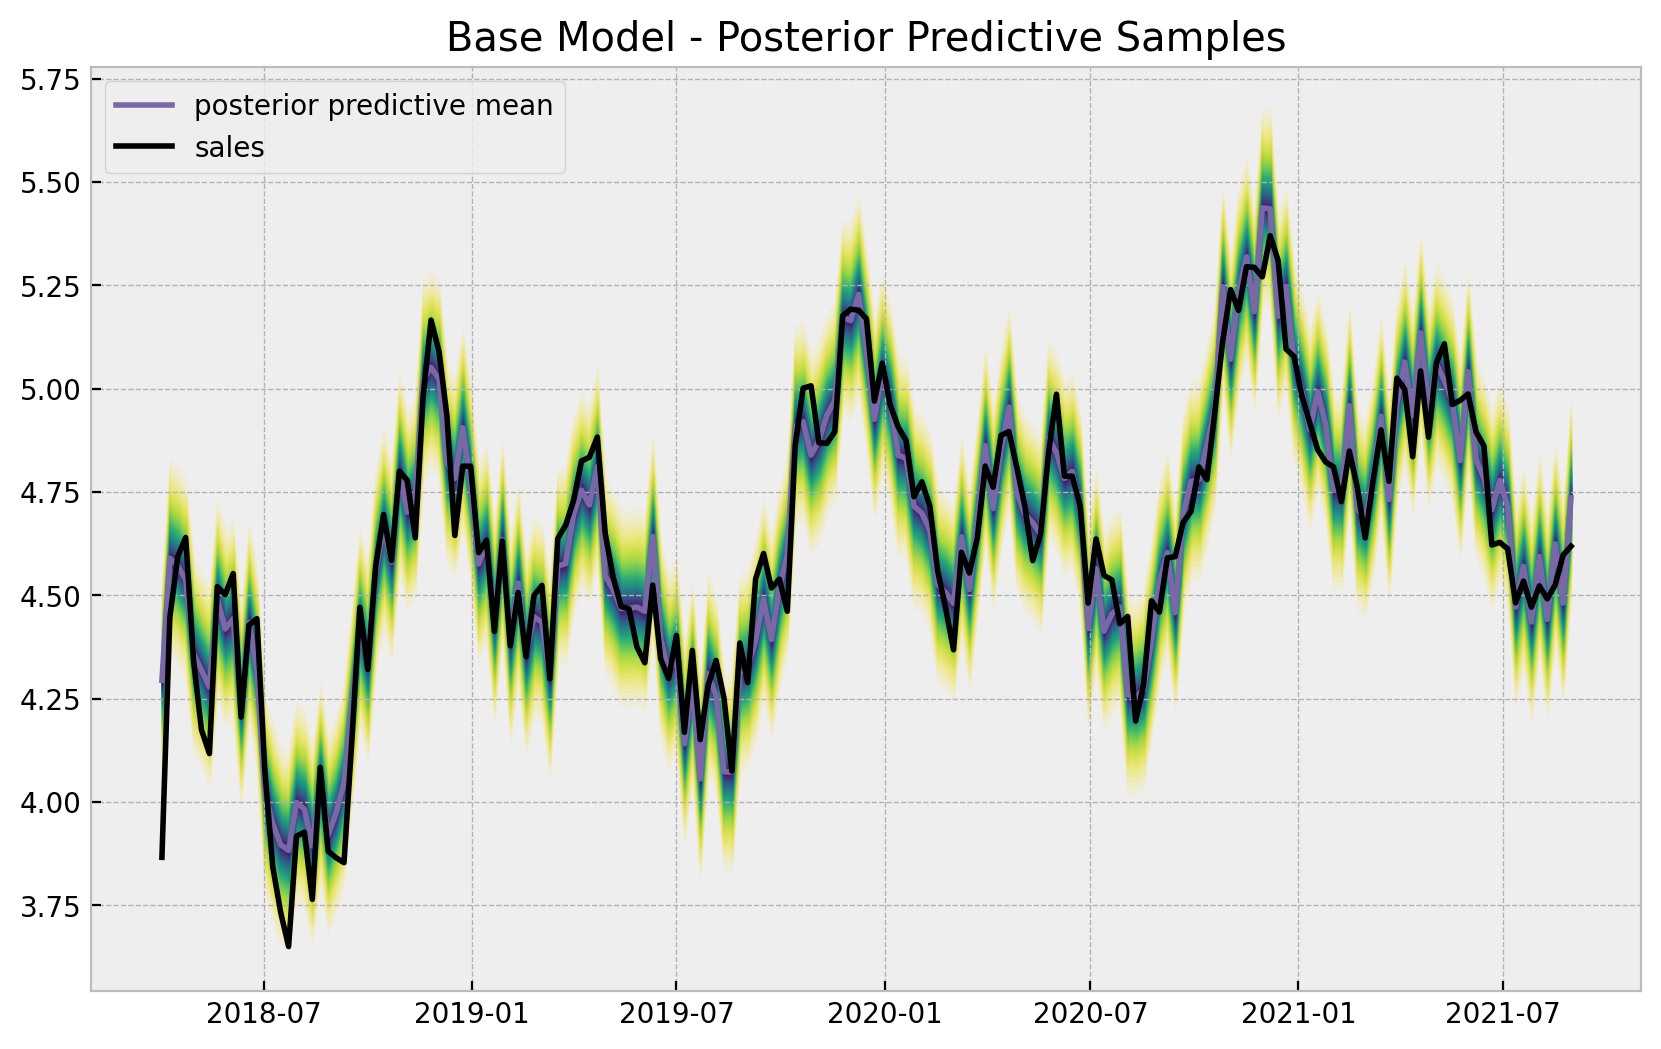

In [37]:
posterior_predictive_likelihood = az.extract(
    data=trend_seasonal_model_posterior_predictive,
    group="posterior_predictive",
    var_names="likelihood",
)

posterior_predictive_likelihood_inv = sales_scaler.inverse_transform(
    X=posterior_predictive_likelihood
)

fig, ax = plt.subplots()

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(posterior_predictive_likelihood_inv, p, axis=1)
    lower = np.percentile(posterior_predictive_likelihood_inv, 100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(
        x=date,
        y1=upper,
        y2=lower,
        color=cmap(color_val),
        alpha=0.1,
    )

sns.lineplot(
    x=date,
    y=posterior_predictive_likelihood_inv.mean(axis=1),
    color="C2",
    label="posterior predictive mean",
    ax=ax,
)
sns.lineplot(
    x=date,
    y=sales,
    color="black",
    label="sales",
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="Base Model - Posterior Predictive Samples");

The base model does capture the trend and seasonality of the data. We can now plot the model components:

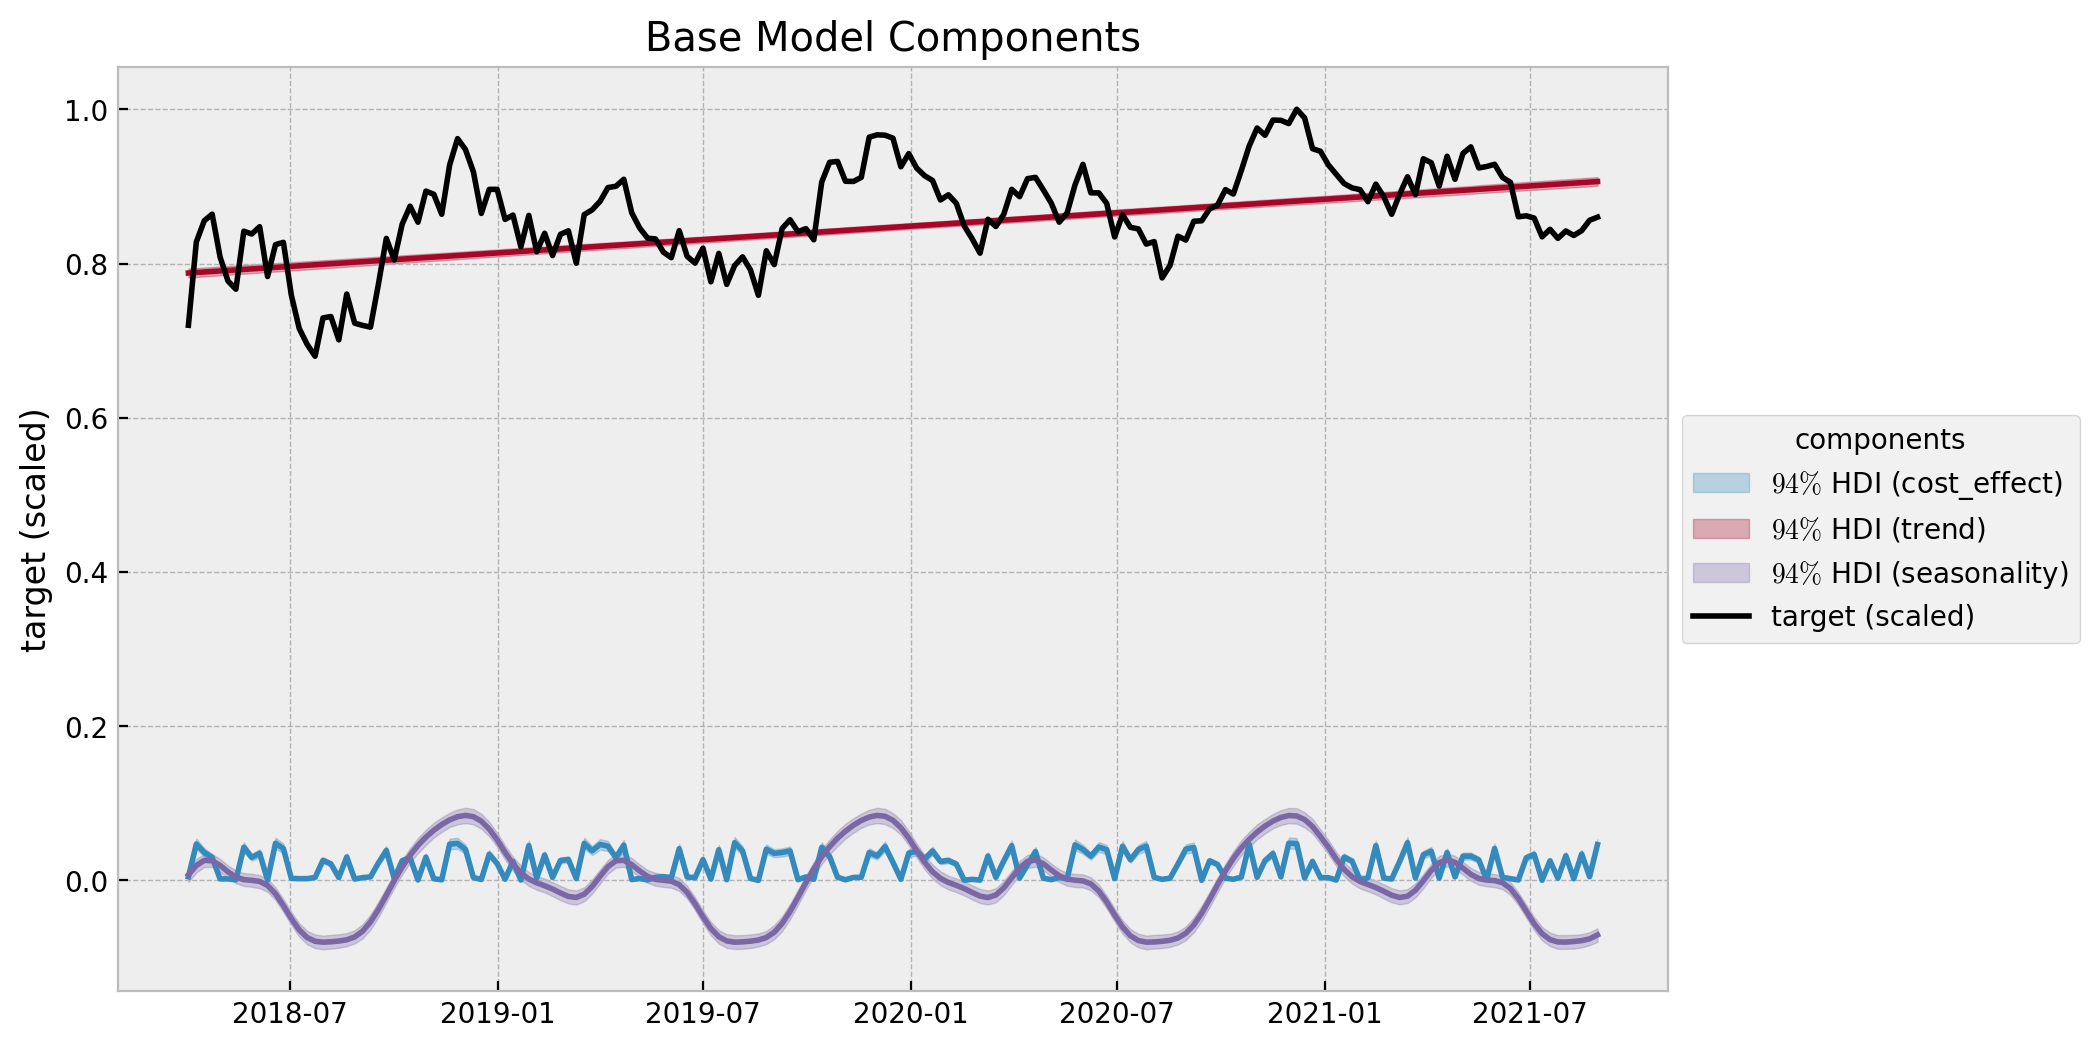

In [38]:
# compute HDI for all the model parameters
model_hdi = az.hdi(ary=trend_seasonal_model_trace)

fig, ax = plt.subplots()

for i, var_effect in enumerate(["cost_effect", "trend", "seasonality"]):
    ax.fill_between(
        x=date,
        y1=model_hdi[var_effect][:, 0],
        y2=model_hdi[var_effect][:, 1],
        color=f"C{i}",
        alpha=0.3,
        label=f"$94\%$ HDI ({var_effect})",
    )
    sns.lineplot(
        x=date,
        y=trend_seasonal_model_trace.posterior[var_effect]
        .stack(sample=("chain", "draw"))
        .mean(axis=1),
        color=f"C{i}",
    )

sns.lineplot(x=date, y=sales_scaled, color="black", alpha=1.0, label="target (scaled)", ax=ax)
ax.legend(title="components", loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Base Model Components", ylabel="target (scaled)");

- Estimated `cost_effect`

Finally, let us look at the estimated effect of `cost` on `sales`. Let's start by looking into the development over time.

In [ ]:
cost_effect_posterior_samples = xr.applsales_ufunc(
    lambda x: cost_scaler.inverse_transform(X=x.reshape(1, -1)),
    trend_seasonal_model_trace.posterior["cost_effect"],
    input_core_dims=[["date"]],
    output_core_dims=[["date"]],
    vectorize=True,
)

cost_effect_hdi = az.hdi(ary=cost_effect_posterior_samples)["cost_effect"]

fig, ax = plt.subplots()
ax.fill_between(
    x=date,
    y1=cost_effect_hdi[:, 0],
    y2=cost_effect_hdi[:, 1],
    color="C0",
    alpha=0.5,
    label="cost_effect 94% HDI",
)
ax.axhline(
    y=cost_effect_posterior_samples.mean(),
    color="C0",
    linestyle="--",
    label=f"posterior mean {cost_effect_posterior_samples.mean().values: 0.3f}",
)
sns.lineplot(x="date", y="cost_effect", color="C3", data=data_df, label="cost_effect", ax=ax)
ax.legend(loc="upper right")
ax.set(title="Media Cost Effect on Sales Estimation - Base Model");

We clearly see that the effect of `cost` is a linear function of `cost` and does not depend on the time, as expected from the model specification. It is interesting to see that the variance of the estimated effect is similar to the real effect of the latest observations.

Next, we simply plot the estimated against the true values.

In [ ]:
fig, ax = plt.subplots()

az.plot_hdi(
    x=z,
    y=cost_effect_posterior_samples,
    color="C0",
    fill_kwargs={"alpha": 0.2, "label": "cost_effect 94% HDI"},
    ax=ax,
)
sns.scatterplot(
    x="cost",
    y="cost_effect_pred_mean",
    color="C0",
    size="index",
    label="cost_effect (pred mean)",
    data=data_df.assign(
        cost_effect_pred_mean=cost_effect_posterior_samples.mean(dim=("chain", "draw"))
    ),
    ax=ax,
)
sns.scatterplot(
    x="cost",
    y="cost_effect",
    color="C3",
    size="index",
    label="cost_effect (true)",
    data=data_df,
    ax=ax,
)
h, l = ax.get_legend_handles_labels()
ax.legend(handles=h[:9], labels=l[:9], loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Base  Model - Estimated Effect");

To encode the time component we map the size of the points to the `index`, which is a global time-component (number of weeks since the first observation). Note that the fitted values do not seem to match the data. This model is too simple to capture the non-linear interactions.

---

### Adstock-Saturation Model

- Features

For the second model we need to express the (geometric) adstock and saturation transformations as tensor operations:

In [21]:
def geometric_adstock(x, alpha: float = 0.0, l_max: int = 12):
    """Geometric adstock transformation."""
    cycles = [
        pt.concatenate(
            [pt.zeros(i), x[: x.shape[0] - i]]
        )
        for i in range(l_max)
    ]
    x_cycle = pt.stack(cycles)
    w = pt.as_tensor_variable([pt.power(alpha, i) for i in range(l_max)])
    return pt.dot(w, x_cycle)


def logistic_saturation(x, lam: float = 0.5):
    """Logistic saturation transformation."""
    return (1 - pt.exp(-lam * x)) / (1 + pt.exp(-lam * x))

- Model Specification

As we want $\alpha$ to be in the interval $(0, 1)$ we use a Beta distribution. Moreover, we choose $\alpha \sim \text{Beta}(1, 1) = \text{Uniform}(0, 1)$ as prior. For $\lambda$ we use a $\text{Gamma}$ distribution as this parameters has to be positive.

In [ ]:
with pm.Model(coords=coords) as adstock_saturation_model:
    # --- data containers ---
    cost_scaled_ = pm.MutableData(name="cost_scaled", value=cost_scaled, dims="date")
    
    # --- priors ---
    ## intercept
    a = pm.Normal(name="a", mu=0, sigma=4)
    ## trend
    b_trend = pm.Normal(name="b_trend", mu=0, sigma=2)
    ## seasonality
    b_fourier = pm.Laplace(name="b_fourier", mu=0, b=2, dims="fourier_mode")
    ## adstock effect
    alpha = pm.Beta(name="alpha", alpha=1, beta=1)
    ## saturation effect
    lam = pm.Gamma(name="lam", alpha=3, beta=1)
    ## regressor
    b_cost = pm.HalfNormal(name="b_cost", sigma=2)
    ## standard deviation of the normal likelihood
    sigma = pm.HalfNormal(name="sigma", sigma=0.5)
    # degrees of freedom of the t distribution
    nu = pm.Gamma(name="nu", alpha=25, beta=2)

    # --- model parametrization ---
    trend = pm.Deterministic("trend", a + b_trend * t, dims="date")
    seasonality = pm.Deterministic(
        name="seasonality", var=pm.math.dot(fourier_features, b_fourier), dims="date"
    )
    cost_adstock = pm.Deterministic(
        name="cost_adstock", var=geometric_adstock(x=cost_scaled_, alpha=alpha, l_max=12), dims="date"
    )
    cost_adstock_saturated = pm.Deterministic(
        name="cost_adstock_saturated",
        var=logistic_saturation(x=cost_adstock, lam=lam),
        dims="date",
    )
    cost_effect = pm.Deterministic(
        name="cost_effect", var=b_cost * cost_adstock_saturated, dims="date"
    )
    mu = pm.Deterministic(name="mu", var=trend + seasonality + cost_effect, dims="date")

    # --- likelihood ---
    pm.StudentT(name="likelihood", nu=nu, mu=mu, sigma=sigma, observed=sales_scaled, dims="date")

    # --- prior samples
    adstock_saturation_model_prior_predictive = pm.sample_prior_predictive()

pm.model_to_graphviz(model=adstock_saturation_model)

- Prior Predictive Samples

In [ ]:
fig, ax = plt.subplots()

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(
        adstock_saturation_model_prior_predictive.prior_predictive["likelihood"],
        p,
        axis=1,
    )
    lower = np.percentile(
        adstock_saturation_model_prior_predictive.prior_predictive["likelihood"], 100 - p, axis=1
    )
    color_val = colors[i]
    ax.fill_between(
        x=date,
        y1=upper.flatten(),
        y2=lower.flatten(),
        color=cmap(color_val),
        alpha=0.1,
    )

sns.lineplot(x=date, y=sales_scaled, color="black", label="target (scaled)", ax=ax)
ax.legend()
ax.set(title="Adstock Saturation Model - Prior Predictive");

- Fit Model

In [ ]:
with adstock_saturation_model:
    adstock_saturation_model_trace = pm.sample(
        nuts_sampler="numpyro",
        draws=6000,
        chains=4,
        idata_kwargs={"log_likelihood": True},
    )
    adstock_saturation_model_posterior_predictive = pm.sample_posterior_predictive(
        trace=adstock_saturation_model_trace,
    )

- Model Diagnostics

In [ ]:
az.summary(
    data=adstock_saturation_model_trace,
    var_names=["a", "b_trend", "b_cost", "alpha", "lam", "sigma", "nu"]
)

We will see later that the values of $\alpha$ and $\lambda$ are very close to the true ones ($0.5$ and $0.15$ respectively) up to a scale defined by the channel scaler. Moreover, the true values (up to this scale) are included in the posterior distributions $94\%$ HDI.

In [ ]:
axes = az.plot_trace(
    data=adstock_saturation_model_trace,
    var_names=["a", "b_trend", "b_fourier", "b_cost", "alpha", "lam", "sigma", "nu"],
    compact=True,
    backend_kwargs={
        "figsize": (12, 12),
        "layout": "constrained"
    },
)
fig = axes[0][0].get_figure()
fig.suptitle("Adstock-Saturation Model - Trace");

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
az.plot_forest(
    data=adstock_saturation_model_trace,
    var_names=["a", "b_trend",  "b_cost", "alpha", "lam", "sigma", "nu"],
    combined=True,
    ax=ax
)
ax.set(
    title="Adstock-Saturation Model: 94.0% HDI",
    xscale="log"
);

- Posterior Predictive Samples

In [ ]:
posterior_predictive_likelihood = az.extract(
    data=adstock_saturation_model_posterior_predictive,
    group="posterior_predictive",
    var_names="likelihood",
)

posterior_predictive_likelihood_inv = endog_scaler.inverse_transform(
    X=posterior_predictive_likelihood
)

fig, ax = plt.subplots()

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(posterior_predictive_likelihood_inv, p, axis=1)
    lower = np.percentile(posterior_predictive_likelihood_inv, 100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(
        x=date,
        y1=upper,
        y2=lower,
        color=cmap(color_val),
        alpha=0.1,
    )

sns.lineplot(
    x=date,
    y=posterior_predictive_likelihood_inv.mean(axis=1),
    color="C2",
    label="posterior predictive mean",
    ax=ax,
)
sns.lineplot(
    x=date,
    y=y,
    color="black",
    label="target",
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="Adstock-Saturation Model - Posterior Predictive Samples");

In [ ]:
# compute HDI for all the model parameters
model_hdi = az.hdi(ary=adstock_saturation_model_trace)

fig, ax = plt.subplots()

for i, var_effect in enumerate(["cost_effect", "trend", "seasonality"]):
    ax.fill_between(
        x=date,
        y1=model_hdi[var_effect][:, 0],
        y2=model_hdi[var_effect][:, 1],
        color=f"C{i}",
        alpha=0.3,
        label=f"$94\%$ HDI ({var_effect})",
    )
    sns.lineplot(
        x=date,
        y=adstock_saturation_model_trace.posterior[var_effect]
        .stack(sample=("chain", "draw"))
        .mean(axis=1),
        color=f"C{i}",
    )

sns.lineplot(x=date, y=sales_scaled, color="black", alpha=1.0, label="target (scaled)", ax=ax)
ax.legend(title="components", loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Adstock-Saturation Model Components", ylabel="target (scaled)");

- Estimated `cost_effect`

In [ ]:
cost_effect_posterior_samples = xr.applsales_ufunc(
    lambda x: endog_scaler.inverse_transform(X=x.reshape(1, -1)),
    adstock_saturation_model_trace.posterior["cost_effect"],
    input_core_dims=[["date"]],
    output_core_dims=[["date"]],
    vectorize=True,
)

cost_effect_hdi = az.hdi(ary=cost_effect_posterior_samples)["cost_effect"]
fig, ax = plt.subplots()
ax.fill_between(
    x=date,
    y1=cost_effect_hdi[:, 0],
    y2=cost_effect_hdi[:, 1],
    color="C0",
    alpha=0.5,
    label="cost_effect 94% HDI",
)
ax.axhline(
    y=cost_effect_posterior_samples.mean(),
    color="C0",
    linestyle="--",
    label=f"posterior mean {cost_effect_posterior_samples.mean().values: 0.3f}",
)
sns.lineplot(x="date", y="cost_effect", color="C3", data=data_df, label="cost_effect", ax=ax)
ax.legend(loc="upper right")
ax.set(title="Media Cost Effect on Sales Estimation - Adstock-Saturation");

This model captures more variance in the effect of `cost` than the base model. This shows that the adstock and saturation transformations do make the difference. Note however that the diminishing returns effect is not present in this model, as the regression coefficient is not time-varying.

We continue by looking into the estimated against the true values for this adstock-saturation model. We would expect to find a non-linear patter because of the composition of these two transformations.

In [ ]:
fig, ax = plt.subplots()

az.plot_hdi(
    x=z,
    y=cost_effect_posterior_samples,
    color="C0",
    fill_kwargs={"alpha": 0.2, "label": "cost_effect 94% HDI"},
    ax=ax,
)
sns.scatterplot(
    x="cost",
    y="cost_effect_pred_mean",
    color="C0",
    size="index",
    label="cost_effect (pred mean)",
    data=data_df.assign(
        cost_effect_pred_mean=cost_effect_posterior_samples.mean(dim=("chain", "draw"))
    ),
    ax=ax,
)
sns.scatterplot(
    x="cost",
    y="cost_effect",
    color="C3",
    size="index",
    label="cost_effect (true)",
    data=data_df,
    ax=ax,
)
h, l = ax.get_legend_handles_labels()
ax.legend(handles=h[:9], labels=l[:9], loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Adstock-Saturation  Model - Estimated Effect");

As for the base-model, we encode the time component as the size of the points. Note that we indeed see a better fit and a non-linear pattern. For low values of `cost` the effect seems constant whereas for larger values we see a non-linear pattern which saturates as expected.

We will deep-dive in the adstock and saturation transformations in the next example.

**Remark:** One can easily vectorize the adstock transformation above to include various channels without using a for loop. Namely,

In [ ]:
def geometric_adstock_vectorized(x, alpha, l_max: int = 12):
    """Vectorized geometric adstock transformation."""
    cycles = [
        pt.concatenate(tensor_list=[pt.zeros(shape=x.shape)[:i], x[: x.shape[0] - i]])
        for i in range(l_max)
    ]
    x_cycle = pt.stack(cycles)
    x_cycle = pt.transpose(x=x_cycle, axes=[1, 2, 0])
    w = pt.as_tensor_variable([pt.power(alpha, i) for i in range(l_max)])
    w = pt.transpose(w)[None, ...]
    return pt.sum(pt.mul(x_cycle, w), axis=2)

Here alpha is a tensor where each dimension corresponds to a channel. Moreover, one can normalize the weights as

In [ ]:
# w / pt.sum(w, axis=2, keepdims=True)

#### ROAS and mROAS

- **ROAS**

In [ ]:
adstock_saturation_model_trace_roas = adstock_saturation_model_trace.copy()

with adstock_saturation_model:
    pm.set_data(new_data={"cost_scaled": np.zeros_like(a=cost_scaled)})
    adstock_saturation_model_trace_roas.extend(
        other=pm.sample_posterior_predictive(trace=adstock_saturation_model_trace_roas, var_names=["likelihood"])
    )

In [ ]:
adstock_saturation_roas_numerator = (
    endog_scaler.inverse_transform(
        X=az.extract(
            data=adstock_saturation_model_posterior_predictive,
            group="posterior_predictive",
            var_names=["likelihood"],
        )
    )
    - endog_scaler.inverse_transform(
        X=az.extract(
            data=adstock_saturation_model_trace_roas,
            group="posterior_predictive",
            var_names=["likelihood"],
        )
    )
).sum(axis=0)

roas_denominator = cost.sum()

adstock_saturation_roas = adstock_saturation_roas_numerator / roas_denominator

In [ ]:
adstock_saturation_roas_mean = adstock_saturation_roas.mean()
adstock_saturation_roas_hdi = az.hdi(ary=adstock_saturation_roas)

g = sns.displot(x=adstock_saturation_roas, kde=True, height=5, aspect=1.5)
ax = g.axes.flatten()[0]
ax.axvline(
    x=adstock_saturation_roas_mean, color="C0", linestyle="--", label=f"mean = {adstock_saturation_roas_mean: 0.3f}"
)
ax.axvline(
    x=adstock_saturation_roas_hdi[0],
    color="C1",
    linestyle="--",
    label=f"HDI_lwr = {adstock_saturation_roas_hdi[0]: 0.3f}",
)
ax.axvline(
    x=adstock_saturation_roas_hdi[1],
    color="C2",
    linestyle="--",
    label=f"HDI_upr = {adstock_saturation_roas_hdi[1]: 0.3f}",
)
ax.axvline(x=roas_true, color="black", linestyle="--", label=f"true = {roas_true: 0.3f}")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Adstock Saturation Model ROAS");

In this case, as for the adstock saturation model is *over estimating the effect* of $z$ on $y$,  this translates into a *smaller* predicted ROAS as compared to the true ROAS.

- **mROAS**

Let's compute the true mROAS. We first need to estimate the effect of $z$ on $y$ by increasing it by $10%$ and then pushing it through the data transformations using the true values of the parameters (see the blog post (Media Effect Estimation with Orbit's KTR Model)[https://juanitorducost.github.io/orbit_mmm/] to see the data generation process). Then we subtract the initial effect (again, note that this just works for additive models!).

In [ ]:
b_cost_true = (np.arange(start=0.0, stop=1.0, step=1/n_obs) + 1) ** (-1.8)

cost_effect_eta = b_cost_true * logistic_saturation(
    x=geometric_adstock(x=(1 + eta) * z, alpha=0.5, l_max=12),
    lam=0.15
).eval()

mroas_true = (cost_effect_eta - data_df["cost_effect"]).sum() / ( eta * cost.sum())

mroas_true

Now, let use compute it from the model.

In [ ]:
eta: float = 0.10

adstock_saturation_model_trace_mroas = adstock_saturation_model_trace.copy()

with adstock_saturation_model:
    pm.set_data(new_data={"cost_scaled": (1 + eta) * cost_scaled})
    adstock_saturation_model_trace_mroas.extend(
        other=pm.sample_posterior_predictive(trace=adstock_saturation_model_trace_mroas, var_names=["likelihood"])
    )

In [ ]:
adstock_saturation_mroas_numerator = (
    endog_scaler.inverse_transform(
        X=az.extract(
            data=adstock_saturation_model_trace_mroas,
            group="posterior_predictive",
            var_names=["likelihood"],
        )
    )
    - endog_scaler.inverse_transform(
        X=az.extract(
            data=adstock_saturation_model_posterior_predictive,
            group="posterior_predictive",
            var_names=["likelihood"],
        )
    )
).sum(axis=0)

mroas_denominator = eta * cost.sum()

adstock_saturation_mroas = adstock_saturation_mroas_numerator / mroas_denominator

In [ ]:
adstock_saturation_mroas_mean = adstock_saturation_mroas.mean()
adstock_saturation_mroas_hdi = az.hdi(ary=adstock_saturation_mroas)

g = sns.displot(x=adstock_saturation_mroas, kde=True, height=5, aspect=1.5)
ax = g.axes.flatten()[0]
ax.axvline(
    x=adstock_saturation_mroas_mean, color="C0", linestyle="--", label=f"mean = {adstock_saturation_mroas_mean: 0.3f}"
)
ax.axvline(
    x=adstock_saturation_mroas_hdi[0],
    color="C1",
    linestyle="--",
    label=f"HDI_lwr = {adstock_saturation_mroas_hdi[0]: 0.3f}",
)
ax.axvline(
    x=adstock_saturation_mroas_hdi[1],
    color="C2",
    linestyle="--",
    label=f"HDI_upr = {adstock_saturation_roas_hdi[1]: 0.3f}",
)
ax.axvline(x=mroas_true, color="black", linestyle="--", label=f"true = {roas_true: 0.3f}")
ax.axvline(x=0.0, color="gray", linestyle="--", label="costero")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title=f"Adstock Saturation Model MROAS ({eta:.0%} increase)");

---

### Adstock-Saturation-Diminishing-Returns (ASDR) Model

In this final model we add a time-varying coefficient for the adstock and saturation transformations (plus controlling for the trend and seasonality). Note that, we ensure the time varying coefficients are all positive by adding an `exp` transformation to the output of the Gaussian random walk.

- Model Specification

In [20]:
with pm.Model(coords=coords) as asdr_model:
    # --- data containers ---
    cost_scaled_ = pm.MutableData(name="cost_scaled", value=cost_scaled, dims="date")

    # --- priors ---
    ## intercept
    a = pm.Normal(name="a", mu=0, sigma=4)
    ## trend
    b_trend = pm.Normal(name="b_trend", mu=0, sigma=2)
    ## seasonality
    b_fourier = pm.Laplace(name="b_fourier", mu=0, b=2, dims="fourier_mode")
    ## adstock effect
    alpha = pm.Beta(name="alpha", alpha=1, beta=1)
    ## saturation effect
    lam = pm.Gamma(name="lam", alpha=1, beta=1)
    ## gaussian random walk standard deviation
    sigma_slope = pm.HalfNormal(name="sigma_slope", sigma=0.05)
    ## standard deviation of the normal likelihood
    sigma = pm.HalfNormal(name="sigma", sigma=0.5)
    # degrees of freedom of the t distribution
    nu = pm.Gamma(name="nu", alpha=10, beta=1)

    # --- model parametrization ---
    trend = pm.Deterministic(name="trend", var=a + b_trend * t, dims="date")
    seasonality = pm.Deterministic(
        name="seasonality", var=pm.math.dot(fourier_features, b_fourier), dims="date"
    )
    slopes = pm.GaussianRandomWalk(
        name="slopes",
        sigma=sigma_slope,
        init_dist=pm.distributions.continuous.Normal.dist(
            name="init_dist", mu=0, sigma=2
        ),
        dims="date",
    )
    cost_adstock = pm.Deterministic(
        name="cost_adstock", var=geometric_adstock(x=cost_scaled_, alpha=alpha, l_max=12), dims="date"
    )
    cost_adstock_saturated = pm.Deterministic(
        name="cost_adstock_saturated",
        var=logistic_saturation(x=cost_adstock, lam=lam),
        dims="date",
    )
    cost_effect = pm.Deterministic(
        name="cost_effect", var=pm.math.exp(slopes) * cost_adstock_saturated, dims="date"
    )
    mu = pm.Deterministic(name="mu", var=trend + seasonality + cost_effect, dims="date")

    # --- likelihood ---
    pm.StudentT(name="likelihood", nu=nu, mu=mu, sigma=sigma, observed=sales_scaled, dims="date")

    # --- prior samples ---
    asdr_model_prior_predictive = pm.sample_prior_predictive()

pm.model_to_graphviz(model=asdr_model)

NameError: name 'geometric_adstock' is not defined

In [ ]:
fig, ax = plt.subplots()

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(
        asdr_model_prior_predictive.prior_predictive["likelihood"],
        p,
        axis=1,
    )
    lower = np.percentile(
        asdr_model_prior_predictive.prior_predictive["likelihood"], 100 - p, axis=1
    )
    color_val = colors[i]
    ax.fill_between(
        x=date,
        y1=upper.flatten(),
        y2=lower.flatten(),
        color=cmap(color_val),
        alpha=0.1,
    )

sns.lineplot(x=date, y=sales_scaled, color="black", label="target (scaled)", ax=ax)
ax.legend()
ax.set(title="Adstock-Saturation-Diminishing-Returns Model - Prior Predictive Samples");

- Model Fit

In [ ]:
with asdr_model:
    asdr_model_trace = pm.sample(
        nuts_sampler="numpyro",
        draws=6_000,
        chains=4,
        idata_kwargs={"log_likelihood": True},
    )
    asdr_model_posterior_predictive = pm.sample_posterior_predictive(
        trace=asdr_model_trace
    )

- Model Diagnostics

In [ ]:
az.summary(
    data=asdr_model_trace,
    var_names=["a", "b_trend", "sigma_slope", "alpha", "lam", "sigma", "nu"]
)

As in the second model, the true values of $\alpha$ and $\lambda$ are included in the posterior distributions $94\%$ hdi (up to a scale as we will see below).

In [ ]:
axes = az.plot_trace(
    data=asdr_model_trace,
    var_names=[
        "a",
        "b_trend",
        "sigma_slope",
        "b_fourier",
        "alpha",
        "lam",
        "sigma",
        "nu",
    ],
    compact=True,
    backend_kwargs={"figsize": (12, 12), "layout": "constrained"},
)
fig = axes[0][0].get_figure()
fig.suptitle("Adstock-Saturation-Diminishing-Returns Model - Trace");

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
az.plot_forest(
    data=asdr_model_trace,
    var_names=["a", "b_trend", "sigma_slope", "alpha", "lam", "sigma", "nu"],
    combined=True,
    ax=ax
)
ax.set(
    title="Adstock-Saturation-Diminishing-Returns Model Model: 94.0% HDI",
    xscale="log"
);

- Posterior Predictive Samples

In [ ]:
posterior_predictive_likelihood = az.extract(
    data=asdr_model_posterior_predictive,
    group="posterior_predictive",
    var_names="likelihood",
)

posterior_predictive_likelihood_inv = endog_scaler.inverse_transform(
    X=posterior_predictive_likelihood
)

fig, ax = plt.subplots()

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(posterior_predictive_likelihood_inv, p, axis=1)
    lower = np.percentile(posterior_predictive_likelihood_inv, 100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(
        x=date,
        y1=upper,
        y2=lower,
        color=cmap(color_val),
        alpha=0.1,
    )

sns.lineplot(
    x=date,
    y=posterior_predictive_likelihood_inv.mean(axis=1),
    color="C2",
    label="posterior predictive mean",
    ax=ax,
)
sns.lineplot(
    x=date,
    y=y,
    color="black",
    label="target",
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="Adstock-Saturation-Diminishing-Returns Model - Posterior Predictive");

In [ ]:
# compute HDI for all the model parameters
model_hdi = az.hdi(ary=asdr_model_trace)

fig, ax = plt.subplots()

for i, var_effect in enumerate(["cost_effect", "trend", "seasonality"]):
    ax.fill_between(
        x=date,
        y1=model_hdi[var_effect][:, 0],
        y2=model_hdi[var_effect][:, 1],
        color=f"C{i}",
        alpha=0.3,
        label=f"$94\%$ HDI ({var_effect})",
    )
    sns.lineplot(
        x=date,
        y=asdr_model_trace.posterior[var_effect]
        .stack(sample=("chain", "draw"))
        .mean(axis=1),
        color=f"C{i}",
    )

sns.lineplot(
    x=date, y=sales_scaled, color="black", alpha=1.0, label="target (scaled)", ax=ax
)
ax.legend(title="components", loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(
    title="Adstock-Saturation-Diminishing-Return Model Components",
    ylabel="target (scaled)",
);

Now we want to deep dive into the parameters $\alpha$ and $\lambda$ of the adstock and saturation transformations respectively. First, let us look into their joint posterior distributions.

In [ ]:
alpha_true = 0.5
lam_true = 0.15
lam_true_scaled = 0.15 * channel_scaler.scale_.item()

fig, ax = plt.subplots(figsize=(6, 5))
az.plot_pair(
    data=asdr_model_trace,
    var_names=["alpha", "lam"],
    kind="kde",
    divergences=True,
    ax=ax
)
ax.axhline(lam_true_scaled, color="C1", linestyle="--", label="$\lambda_{true} (scaled)$")
ax.axvline(alpha_true, color="C4", linestyle="--", label="$\\alpha_{true}$")
ax.legend(title="true params", loc="upper right")
ax.set(
    title="Adstock-Saturation-Diminishing-Returns Model",
    xlabel="$\\alpha$",
    ylabel="$\lambda$"
);

The true values are quite close to the posterior mode. Note that there seems to be a weak negative correlation between these two parameters.

In [ ]:
corr, _ = pearsonr(
    x=asdr_model_trace.posterior["alpha"].stack(sample=("chain", "draw")).to_numpy(),
    y=asdr_model_trace.posterior["lam"].stack(sample=("chain", "draw")).to_numpy()
)

print(f"Correlation between alpha and lambda {corr: 0.3f}");

- $\alpha$ deep dive

Now, we can look into the posterior distribution of the of `cost` when applying the `geometric_adstock` transformation for all the $\alpha$ posterior samples.

In [ ]:
alpha_posterior = az.extract(data=asdr_model_trace, group="posterior", var_names="alpha")

alpha_posterior_samples = alpha_posterior.to_numpy()[:100]

# pass z through the adstock transformation
geometric_adstock_posterior_samples = np.array([
    geometric_adstock(x=z, alpha=x).eval()
    for x in alpha_posterior_samples
])

Let us compare the estimates against the true values.

In [ ]:
geometric_adstock_hdi = az.hdi(ary=geometric_adstock_posterior_samples)

yerr = geometric_adstock_hdi[:, 1] - geometric_adstock_hdi[:, 0]

fig, ax = plt.subplots(figsize=(8, 7))

markers, caps, bars = ax.errorbar(
    x=data_df["cost_adstock"], 
    y=geometric_adstock_posterior_samples.mean(axis=0), 
    yerr=yerr/2,
    color="C0",
    fmt='o',
    ms=1,
    capsize=5,
    label="$94\%$ HDI",
)
[bar.set_alpha(0.3) for bar in bars]
ax.axline(
    xy1=(10, 10),
    slope=1.0,
    color="black",
    linestyle="--",
    label="diagonal"
)
ax.legend()
ax.set(
    title="Adstock-Saturation-Diminishing-Returns Model - $\\alpha$ Estimation",
    xlabel="cost_adstock (true)",
    ylabel="cost_adstock (pred)",
);

We see that the model is capturing the adstock transformation (within the model uncertainty limits). Note how the hdi intervals increase as a function of `cost_adstock` (true).

- $\lambda$ deep dive

Next we look into the $\lambda$ parameter. We follow the a similar strategy as above.

In [ ]:
lam_posterior = (
    az.extract(data=asdr_model_trace, group="posterior", var_names="lam")
    / channel_scaler.scale_.item()
)

lam_posterior_samples = lam_posterior.to_numpy()[:100]

logistic_saturation_posterior_samples = np.array(
    [
        logistic_saturation(x=x, lam=lam_posterior_samples).eval()
        for x in data_df["cost_adstock"].values
    ]
)

We can now plot the estimated saturation curve against the true one.

In [ ]:
logistic_saturation_hdi = az.hdi(ary=logistic_saturation_posterior_samples.T)

yerr = logistic_saturation_hdi[:, 1] - logistic_saturation_hdi[:, 0]


fig, ax = plt.subplots(figsize=(7, 6))

latex_function = r"$x\longmapsto \frac{1 - e^{-\lambda x}}{1 + e^{-\lambda x}}$"

markers, caps, bars = ax.errorbar(
    x=data_df["cost_adstock"], 
    y=logistic_saturation_posterior_samples.mean(axis=1), 
    yerr=yerr/2,
    color="C0",
    fmt='o',
    ms=3,
    capsize=5,
    label="$94\%$ HDI",
)
[bar.set_alpha(0.3) for bar in bars]
sns.lineplot(
    x="cost_adstock",
    y="cost_adstock_saturated",
    color="C2",
    label=latex_function,
    data=data_df,
    ax=ax
)
ax.legend(loc="lower right", prop={"size": 15})
ax.set(
    title="Adstock-Saturation-Diminishing-Returns Model - $\lambda$ Estimation",
    xlabel="cost_adstock (true)",
    ylabel="cost_adstock_saturaded (pred)",
);

The true saturation curve lies within the $94\%$ hdi estimated by the model.

- Transformation Deep-Dive

In [ ]:
model_hdi_inv = az.hdi(ary=asdr_model_trace)

fig, axes = plt.subplots(
    nrows=4, ncols=1, figsize=(12, 9), sharex=True, sharey=False, layout="constrained"
)

sns.lineplot(
    x=date,
    y=z,
    color="black",
    ax=axes[0],
)
axes[0].set(title="cost")

for i, var_name in enumerate(["cost_adstock", "cost_adstock_saturated", "cost_effect"]):

    var_name_posterior = endog_scaler.inverse_transform(
            X=az.extract(data=asdr_model_trace, group="posterior", var_names=var_name)
        )
    var_name_hdi =az.hdi(ary=var_name_posterior.T)

    ax = axes[i + 1]
    sns.lineplot(
        x=date,
        y=var_name_posterior.mean(axis=1),
        color=f"C{i}",
        ax=ax,
    )
    ax.fill_between(
        x=date,
        y1=var_name_hdi[:, 0],
        y2=var_name_hdi[:, 1],
        color=f"C{i}",
        alpha=0.5,
    )
    ax.set(title=var_name)


- Estimated `cost_effect`

Let us look into the estimated effect of `cost` on `sales` inferred by the model against the true one from the data generation process.

In [ ]:
cost_effect_posterior_samples = xr.applsales_ufunc(
    lambda x: endog_scaler.inverse_transform(X=x.reshape(1, -1)),
    asdr_model_trace.posterior["cost_effect"],
    input_core_dims=[["date"]],
    output_core_dims=[["date"]],
    vectorize=True,
)

cost_effect_hdi = az.hdi(ary=cost_effect_posterior_samples)["cost_effect"]

fig, ax = plt.subplots()
ax.fill_between(
    x=date,
    y1=cost_effect_hdi[:, 0],
    y2=cost_effect_hdi[:, 1],
    color="C0",
    alpha=0.5,
    label="cost_effect 94% HDI",
)
ax.axhline(
    y=cost_effect_posterior_samples.mean(),
    color="C0",
    linestyle="--",
    label=f"posterior mean {cost_effect_posterior_samples.mean().values: 0.3f}",
)
sns.lineplot(x="date", y="cost_effect", color="C3", data=data_df, label="cost_effect", ax=ax)
ax.legend(loc="upper right")
ax.set(
    title="Media Cost Effect Estimation - Adstock-Saturation-Diminishing-Returns Model"
);

As expected, we get a very good fit. In particular, the model is capturing the time-varying effect as a result of the gaussian random walk component. As above, we can now look into the estimated vs true scatter plot.

In [ ]:
fig, ax = plt.subplots()

az.plot_hdi(
    x=z,
    y=cost_effect_posterior_samples,
    color="C0",
    fill_kwargs={"alpha": 0.2, "label": "cost_effect 94% HDI"},
    ax=ax,
)
sns.scatterplot(
    x="cost",
    y="cost_effect_pred_mean",
    color="C0",
    size="index",
    label="cost_effect (pred mean)",
    data=data_df.assign(
        cost_effect_pred_mean=cost_effect_posterior_samples.mean(dim=("chain", "draw"))
    ),
    ax=ax,
)
sns.scatterplot(
    x="cost", y="cost_effect", color="C3", size="index", label="cost_effect (true)", data=data_df
)
h, l = ax.get_legend_handles_labels()
ax.legend(handles=h[:9], labels=l[:9], loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Adstock-Saturation-Diminishing-Returns Model - Estimated Effect");

It is interesting to see that the non-linear pattern does not look precisely as a logistic saturation. One of the main reasons for this is the diminishing returns in the time component. We can better see the logistic-like saturation if we factor the time component, for example by splitting by year:

In [ ]:
cost_effect_hdi = az.hdi(ary=cost_effect_posterior_samples)["cost_effect"]

data_df = data_df.assign(
    cost_effect_pred_mean=cost_effect_posterior_samples.mean(dim=("chain", "draw")),
    cost_effect_hdi_lower=cost_effect_hdi[:, 0],
    cost_effect_hdi_upper=cost_effect_hdi[:, 1],
)

In [ ]:
fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(10, 9), sharex=True, sharey=True, layout="constrained"
)

axes = axes.flatten()

for i, year in enumerate(data_df["year"].sort_values().unique()):
    ax = axes[i]
    mask = f"year == {year}"

    yerr = (
        data_df.query(mask)["cost_effect_hdi_upper"]
        - data_df.query(mask)["cost_effect_hdi_lower"]
    )

    markers, caps, bars = ax.errorbar(
        x=data_df.query(mask)["cost"],
        y=data_df.query(mask)["cost_effect_pred_mean"],
        yerr=yerr / 2,
        color="C0",
        fmt="o",
        ms=0,
        capsize=5,
        label="estimated effect",
    )
    [bar.set_alpha(0.3) for bar in bars]
    sns.regplot(
        x="cost",
        y="cost_effect_pred_mean",
        order=2,
        color="C0",
        label="pred mean effect",
        data=data_df.query(mask),
        ax=ax,
    )
    sns.regplot(
        x="cost",
        y="cost_effect",
        order=2,
        color="C3",
        label="true effect",
        data=data_df.query(mask),
        ax=ax,
    )
    if i == 0:
        ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=3)
    else:
        ax.legend().remove()
    ax.set(title=f"{year}")

fig.suptitle("Media Cost Effect Estimation - ASDR Model", y=1.05);

The results look very good! These are exactly the curves we would need for decision making and budget allocation.

**Remark:** Note that this plot looks very similar to the one obtained in the post [Media Effect Estimation with Orbit's KTR Model](https://juanitorducost.github.io/orbit_mmm/). The main difference is that in the previous post we could only estimated the effect of `cost_adstock` on `sales` while in this one we estimate the effect of `cost` on `sales` directly by learning the adstock effect from the data.

#### ROAS and mROAS

- **ROAS**

In [ ]:
asdr_model_trace_roas = asdr_model_trace.copy()

with asdr_model:
    pm.set_data(new_data={"cost_scaled": np.zeros_like(a=cost_scaled)})
    asdr_model_trace_roas.extend(
        other=pm.sample_posterior_predictive(trace=asdr_model_trace_roas, var_names=["likelihood"])
    )

In [ ]:
asdr_roas_numerator = (
    endog_scaler.inverse_transform(
        X=az.extract(
            data=asdr_model_posterior_predictive,
            group="posterior_predictive",
            var_names=["likelihood"],
        )

    )
    - endog_scaler.inverse_transform(
        X=az.extract(
            data=asdr_model_trace_roas,
            group="posterior_predictive",
            var_names=["likelihood"],
        )
    )
).sum(axis=0)

roas_denominator = cost.sum()

asdr_roas = asdr_roas_numerator / roas_denominator


In [ ]:
asdr_roas_mean = np.median(asdr_roas)
asdr_roas_hdi = az.hdi(ary=asdr_roas)

g = sns.displot(x=asdr_roas, kde=True, height=5, aspect=1.5)
ax = g.axes.flatten()[0]
ax.axvline(
    x=asdr_roas_mean, color="C0", linestyle="--", label=f"mean = {asdr_roas_mean: 0.3f}"
)
ax.axvline(
    x=asdr_roas_hdi[0],
    color="C1",
    linestyle="--",
    label=f"HDI_lwr = {asdr_roas_hdi[0]: 0.3f}",
)
ax.axvline(
    x=asdr_roas_hdi[1],
    color="C2",
    linestyle="--",
    label=f"HDI_upr = {asdr_roas_hdi[1]: 0.3f}",
)
ax.axvline(x=roas_true, color="black", linestyle="--", label=f"true = {roas_true: 0.3f}")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Adstock-Saturation-Diminishing-Returns Model ROAS");

As expected, the true and predicted values are very close! Also, the HDI is much smaller than the adstock-saturation model.

- **mROAS**

In [ ]:
eta: float = 0.10

asdr_model_trace_mroas = asdr_model_trace.copy()

with asdr_model:
    pm.set_data(new_data={"cost_scaled": (1 + eta) * cost_scaled})
    asdr_model_trace_mroas.extend(
        other=pm.sample_posterior_predictive(trace=asdr_model_trace_mroas, var_names=["likelihood"])
    )

In [ ]:
asdr_mroas_numerator = (
    endog_scaler.inverse_transform(
        X=az.extract(
            data=asdr_model_trace_mroas,
            group="posterior_predictive",
            var_names=["likelihood"],
        )
    )
    - endog_scaler.inverse_transform(
        X=az.extract(
            data=asdr_model_posterior_predictive,
            group="posterior_predictive",
            var_names=["likelihood"],
        )
    )
).sum(axis=0)

mroas_denominator = eta * cost.sum()

asdr_mroas = asdr_mroas_numerator / mroas_denominator

In [ ]:
asdr_mroas_mean = asdr_mroas.mean()
asdr_mroas_hdi = az.hdi(ary=asdr_mroas)

g = sns.displot(x=asdr_mroas, kde=True, height=5, aspect=1.5)
ax = g.axes.flatten()[0]
ax.axvline(
    x=asdr_mroas_mean, color="C0", linestyle="--", label=f"mean = {asdr_mroas_mean: 0.3f}"
)
ax.axvline(
    x=asdr_mroas_hdi[0],
    color="C1",
    linestyle="--",
    label=f"HDI_lwr = {asdr_mroas_hdi[0]: 0.3f}",
)
ax.axvline(
    x=asdr_mroas_hdi[1],
    color="C2",
    linestyle="--",
    label=f"HDI_upr = {asdr_roas_hdi[1]: 0.3f}",
)
ax.axvline(x=0.0, color="gray", linestyle="--", label="costero")
ax.axvline(x=mroas_true, color="black", linestyle="--", label=f"true = {mroas_true: 0.3f}")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title=f"Adstock-Saturation-Diminishing-Returns Model MROAS ({eta:.0%} increase)");

The estimated mROAS mean and the true values aver almost the same!

## Model Comparison

To end this notebook, let us compare the three models.

In [ ]:
dataset_dict = {
    "base_model": base_model_trace,
    "trend_seasonal_model": trend_seasonal_model_trace,
    "adstock_saturation_model": adstock_saturation_model_trace,
    "asdr_model": asdr_model_trace,
}

az.compare(compare_dict=dataset_dict, ic="loo", method="stacking", scale="log")

We clearly see that the `asdr_model` is the best one (no surprise here). Let's finally compare the posterior distributions for the three models. 

In [ ]:
axes = az.plot_forest(
    data=[base_model_trace, adstock_saturation_model_trace, asdr_model_trace],
    model_names=["base_model", "trend_seasonal_model", "adstock_saturation_model", "asdr_model"],
    var_names=["a", "b_trend", "b_cost", "sigma_slope", "alpha", "lam", "sigma"],
    combined=True,
    figsize=(10, 7),
);

In [ ]:
axes = az.plot_forest(
    data=[base_model_trace, adstock_saturation_model_trace, asdr_model_trace],
    model_names=["base_model", "trend_seasonal_model", "adstock_saturation_model", "asdr_model"],
    var_names=["nu"],
    combined=True,
    figsize=(8, 3),
);

Finally, let's compare the estimated ROAS and mROAS of all models. First we collect the samples: